In [116]:
# if pip install isnt working:
# !python --version

# !curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py
# !python get-pip.py

In [117]:
# requirements:
#!python -m 
# pip install pandas yfinance requests numpy matplotlib PyWavelets seaborn scikit-learn scipy
# import the necessary libraries.
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import requests
import pywt
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
from scipy import stats

In [118]:
# First we need a dataset for this project, I was unable to find a complete dataset from a reputable source that suited my specific use case. So decided to look into collecting my own data and compiling one myself. 
# I'll be using the yfinance library to get the stock market data (in future I would like to include more data sources such as those from Tiingo).
# I'll start by making a directory for the datasets.csv that we will need to generate.

project_root = Path(os.getcwd()) #find file path of the working directory for notebook scripts.
output_dir = project_root / "dataset"
#check to see if the directory exists, make it if it doesn't
output_dir.mkdir(parents=True, exist_ok=True)
output_path = output_dir / "2015-2025_dataset.csv"

# defining the date range for the dataset. 
# we'll be using start and end dates multiples times so its best to define them here only once, its likely we'll need to generate seperate time frames for the test/training split.
start_date = "2015-01-01"
end_date = "2025-02-01"

date_range = pd.date_range(start=start_date, end=end_date, freq='D') # Format: YYYY-MM-DD, "freq" is the frequency of dates in this case: ='D' means daily.

df = pd.DataFrame(index=date_range)

I will need to define a few functions that are needed to be run before I can generate the completed dataset require the for the AI model to work. The first block here is Largely AI assisted with Claude sonnet 3.5: Using the yahoo finance API, this block pulls the historical trading data needed for each individual major global stock exhange for volume and closed price, then converted the currencies to USD using forex data (also from the yfinance API) and returns the results.

In [119]:
def fetch_stock_data(symbol: str, currency: str, start_date: str, end_date: str) -> pd.DataFrame:
    df = yf.download(symbol, start=start_date, end=end_date)
    if df.empty:
        return pd.DataFrame(index=date_range)
        
    # Create a new DataFrame with just Close and Volume
    result = pd.DataFrame(index=df.index)
    result['Close'] = df['Close']
    result['Volume'] = df['Volume']
    
    # Get currency conversion rate if needed
    if currency:
        fx_data = yf.download(currency, start=start_date, end=end_date)
        if not fx_data.empty:
            fx_rate = fx_data['Close']
            
            # Ensure both dataframes have datetime index
            result.index = pd.to_datetime(result.index)
            fx_rate.index = pd.to_datetime(fx_rate.index)
            
            # Find common dates between stock and forex data
            common_dates = result.index.intersection(fx_rate.index)            
            # Keep only dates where we have both stock and forex data
            result = result.loc[common_dates]
            fx_rate = fx_rate.loc[common_dates]
            
            # Convert only Close prices to USD using element-wise multiplication
            result['Close'] = result['Close'].values * fx_rate.values
        else:
            return pd.DataFrame(index=date_range)
    
    # Handle volume based on the index
    if symbol in ['^N225', '^HSI']:  # Asian markets often have lower nominal volumes
        result['Volume'] = result['Volume'] / 1_000  # Convert to thousands
    else:
        result['Volume'] = result['Volume'] / 1_000_000  # Convert to millions
                
    # Add sanity checks for extreme values
    if result['Close'].max() > 50000 or result['Close'].min() < 1:
        return pd.DataFrame(index=date_range)
        
    if result['Volume'].min() == 0 or result['Volume'].max() / result['Volume'].min() > 1000:
        return pd.DataFrame(index=date_range)
        
    # Rename columns with symbol prefix
    result = result.rename(columns={
        'Close': f'{symbol}_Close_USD',
        'Volume': f'{symbol}_Volume_M'  # M for millions or thousands for Asian markets
    })
    
    # Reindex to full date range without filling
    result = result.reindex(date_range)
    return result

This next block calls the previous blocks function iteratively for each of the 7 stock markets I have decided to include in the data collection. After aquiring the entire daily closed USD price and volume data for each exchange they are averaged together into two combined columns for the previously specified time frame.

- "(Tang et al.) demonstrates strong correlations between global market indices and crypto markets" 
- "The inclusion of Asian markets (Nikkei, Hang Seng) is particularly relevant as studies have shown significant Bitcoin trading volume from these regions" 
- "The SKEW index; research shows its effectiveness in predicting "black swan" events in crypto markets, OVX (Oil Volatility) "Enhancing Bitcoin Price Prediction with Deep Learning" shows volatility indices are key predictors"

- ""Cryptocurrency Valuation: An Explainable AI Approach" validates the use of on-chain metrics as fundamental indicators" - "Hash rate and mining difficulty are particularly important as they reflect network security and mining economics"
- "Transaction metrics provide insight into network usage and adoption"

- "Deep Learning for Financial Applications: A Survey" supports the inclusion of traditional safe-haven assets like gold, The DXY (Dollar Index) inclusion is supported by research showing strong inverse correlations with Bitcoin during certain market conditions"

In [120]:
def get_market_stock_data(start_date, end_date):
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    result_df = pd.DataFrame(index=date_range)
    
    # Define indices with their currencies
    indices = {
        'GDAXI': {'symbol': '^GDAXI', 'currency': 'EURUSD=X'},    # Germany DAX
        'IXIC': {'symbol': '^IXIC', 'currency': None},            # NASDAQ (already in USD)
        'DJI': {'symbol': '^DJI', 'currency': None},              # Dow Jones (already in USD)
        'N225': {'symbol': '^N225', 'currency': 'JPYUSD=X'},      # Nikkei
        'STOXX50E': {'symbol': '^STOXX', 'currency': 'EURUSD=X'}, # Euro STOXX 50
        'HSI': {'symbol': '^HSI', 'currency': 'HKDUSD=X'},        # Hang Seng
        'FTSE': {'symbol': '^FTSE', 'currency': 'GBPUSD=X'}       # FTSE 100
    }
    
    # Fetch data for all indices
    combined_df = pd.DataFrame(index=date_range)
    
    for name, info in indices.items():
        index_data = fetch_stock_data(info['symbol'], info['currency'], start_date, end_date)
        if not index_data.empty and len(index_data.columns) > 0:
            combined_df = pd.concat([combined_df, index_data], axis=1)
    
    # Calculate global averages
    close_cols = [col for col in combined_df.columns if str(col).endswith('_Close_USD')]
    volume_cols = [col for col in combined_df.columns if str(col).endswith('_Volume_M')]
    
    if close_cols and volume_cols:
        result_df = pd.DataFrame(index=date_range)
        result_df['Global averaged stocks(USD)'] = combined_df[close_cols].mean(axis=1, skipna=True)
        result_df['Global averaged stocks (volume)'] = combined_df[volume_cols].mean(axis=1, skipna=True)
        
        return result_df
    return pd.DataFrame(index=date_range, columns=['Global averaged stocks(USD)', 'Global averaged stocks (volume)'])

This next function works similar to the previous, collecting the US Dollar index (DXY) and the gold futures data from Yahoo Finance. Along with the Bitcoin-USD paring with its respective volume data.

In [121]:
def get_currency_metrics(start_date, end_date):   
    result_df = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date, freq='D'))
    # Get DXY (US Dollar Index)
    dxy = yf.download("DX-Y.NYB", start=start_date, end=end_date)
    result_df['Currency US Dollar Index'] = dxy['Close']
    
    # Get Gold Futures
    gold = yf.download("GC=F", start=start_date, end=end_date)
    result_df['Currency Gold Futures'] = gold['Close']
    
    # Get Bitcoin price data
    btc = yf.download("BTC-USD", start=start_date, end=end_date)
    result_df['BTC/USD'] = btc['Close']
    
    # Get Bitcoin price data
    btc = yf.download("BTC-USD", start=start_date, end=end_date)
    result_df['BTC Volume'] = btc['Volume']
    
    # Calculate Gold/BTC Ratio where BTC price is not zero or null
    result_df['Gold/BTC Ratio'] = result_df['Currency Gold Futures'].div(result_df['BTC/USD'].replace(0, float('nan')))
    result_df['Gold/BTC Ratio'] = result_df['Gold/BTC Ratio']
    
    return result_df

Same again here, with some additional assistence from Clude AI, and using the blockchain.info API, this function collects the individual "on chain" metrics that were chosen for inclusion in this dataset.

In [122]:
def get_blockchain_metric(metric_name, start_date, end_date):
    
    # Fetch single blockchain metric one by one, from the Blockchain.info API.
 
    # Convert dates to timestamps
    start_ts = int(datetime.strptime(start_date, "%Y-%m-%d").timestamp())
    end_ts = int(datetime.strptime(end_date, "%Y-%m-%d").timestamp())
    
    # Fetch data from API with updated URL structure
    url = f"{"https://api.blockchain.info"}/{metric_name}"
    params = {
        "timespan": "all",
        "start": start_ts,
        "end": end_ts,
        "format": "json",
        "sampled": "true"
    }
    
    response = requests.get(url, params=params)
    if response.status_code != 200:
        return pd.Series(index=pd.date_range(start=start_date, end=end_date, freq='D'))
        
    data = response.json()
    
    # Check if the response has the expected structure
    if not isinstance(data, dict) or 'values' not in data:
        return pd.Series(index=pd.date_range(start=start_date, end=end_date, freq='D'))
    
    # Process the values
    values = []
    timestamps = []
    for entry in data['values']:
        if isinstance(entry, (list, tuple)) and len(entry) >= 2:
            timestamps.append(entry[0])
            values.append(float(entry[1]))
        elif isinstance(entry, dict) and 'x' in entry and 'y' in entry:
            timestamps.append(entry['x'])
            values.append(float(entry['y']))
    
    if not values:
        return pd.Series(index=pd.date_range(start=start_date, end=end_date, freq='D'))
    
    # Create DataFrame and handle data types
    df = pd.DataFrame({'timestamp': timestamps, 'value': values})
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s').dt.normalize()
    df = df.drop_duplicates('timestamp', keep='last')
    df.set_index('timestamp', inplace=True)
    
    # Handle potential overflow for large numbers
    df['value'] = df['value'].astype('float64')
    
    # Reindex to ensure consistent date range
    return df['value'].reindex(date_range)

This function calls the previous block iteratively for each metric of "on chain" data, it is unclear to me which if any of these metrics have high enough correlation with the BTC-USD price movement to warrent final selection. As a reult I decided to include more than I would expect are required in the interest of thoroughness.

In [123]:
def get_onchain_metrics(start_date, end_date):
    result_df = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date, freq='D'))
    # Define metrics and their API endpoints with updated paths
    metrics = {
        'Onchain Active Addresses': 'charts/n-unique-addresses',
        'Onchain Transaction Count': 'charts/n-transactions',
        'Onchain Hash Rate (GH/s)': 'charts/hash-rate',
        'Onchain Mining Difficulty': 'charts/difficulty',
        'Onchain Transaction Fees (BTC)': 'charts/transaction-fees',
        'Onchain Median Confirmation Time (min)': 'charts/median-confirmation-time'
    }
    
    # Fetch each metric
    for col_name, metric_name in metrics.items():
        series = get_blockchain_metric(metric_name, start_date, end_date)
        result_df[col_name] = series
        
        # Handle missing values for each metric appropriately
        if col_name in ['Onchain Mining Difficulty', 'Onchain Hash Rate (GH/s)']:
            result_df[col_name] = result_df[col_name]
        elif col_name in ['Onchain Transaction Count', 'Onchain Active Addresses']:
            result_df[col_name] = result_df[col_name]
        else:
            result_df[col_name] = result_df[col_name]
    
    return result_df

These additional metrics track the volatility of the S&P500 stock market and the crude oil volatility index.

In [124]:
def get_volatility_indices(start_date, end_date):    
    df = pd.DataFrame()
    
    # Get CBOE SKEW Index from Yahoo Finance
    skew = yf.download("^SKEW", start=start_date, end=end_date)
    df['Volatility_CBOE SKEW Index'] = skew['Close']
    
    # Get VIX
    vix = yf.download("^VIX", start=start_date, end=end_date)
    df['Volatility_CBOE Volatility Index (VIX)'] = vix['Close']
    
    # Get Oil VIX
    ovx = yf.download("^OVX", start=start_date, end=end_date)
    df['Volatility_Crude Oil Volatility Index (OVX)'] = ovx['Close']
    
    return df

https://medium.com/@100trillionUSD/modeling-bitcoins-value-with-scarcity-91fa0fc03e25

https://medium.com/@100trillionUSD/bitcoin-stock-to-flow-cross-asset-model-50d260feed12

https://newhedge.io/bitcoin/stock-to-flow

Here I would like to include and calculate the "Stock to Flow" model intially conceptualized by "PlanB".

Cluade AI helped with the S2F model calculations:

In [125]:
def calculate_stock_to_flow(start_date, end_date):
    
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    s2f_df = pd.DataFrame(index=date_range)
    
    # API parameters
    params = {
        "timespan": "all",
        "start": int(pd.Timestamp(start_date).timestamp()),
        "end": int(pd.Timestamp(end_date).timestamp()),
        "format": "json",
        "sampled": "false"
    }
    
    # Get total supply
    response = requests.get("https://api.blockchain.info/charts/total-bitcoins", params=params)
    if response.status_code == 200:
        data = response.json()['values']
        df = pd.DataFrame(data, columns=['x', 'y'])
        df['timestamp'] = pd.to_datetime(df['x'], unit='s').dt.normalize()
        stock = df.groupby('timestamp')['y'].mean()
        stock = stock.reindex(date_range).interpolate(method='linear')
        
        # Calculate flow based on Bitcoin halving schedule
        s2f_df['timestamp'] = date_range
        s2f_df['block height'] = ((s2f_df['timestamp'] - pd.Timestamp('2009-01-03')) / pd.Timedelta(minutes=10)).astype(int) # "genesis block" date (January 3, 2009) the first BTC block to be mined.
        
        # Calculate daily block rewards based on halving schedule
        def get_block_reward(block_height):
            halvings = block_height // 210000 # Roughly every 4 years there is a BTC "halving event" (when the mining rewards are halved) this is every 210,000 blocks.
            return 50 / (2 ** halvings)
        
        s2f_df['daily production'] = s2f_df['block height'].apply(get_block_reward) * 144  # Timing by 144 gives us the total daily Bitcoin production (24 hours * 60 minutes) / 10 minutes = 144 blocks per day, ".apply(get_block_reward)" calculates the reward for each block height.
        
        # Calculate S2F ratio (stock divided by yearly flow)
        s2f_df['s2f ratio'] = stock / (s2f_df['daily production'] * 365)
        
        # Calculate expected price using S2F model
        # Using the formula: Price = exp(-1.84) * S2F^3.36
        s2f_df['S2F Model'] = np.exp(-1.84) * (s2f_df['s2f ratio'] ** 3.36)
        
        # Convert to USD and handle any extreme values
        s2f_df['S2F Model'] = s2f_df['S2F Model']
        
        return s2f_df[['S2F Model']]
    
    return pd.DataFrame(index=date_range)

Main fuction for compiling, saving and ordering all the columns required for this dataset.

In [126]:
# Get all data components
components = [
    ('Stockmarket', get_market_stock_data(start_date, end_date)),
    ('Currency Metrics', get_currency_metrics(start_date, end_date)),
    ('On-chain Metrics', get_onchain_metrics(start_date, end_date)),
    ('Volatility Indices', get_volatility_indices(start_date, end_date)),
    ('S2F Model', calculate_stock_to_flow(start_date, end_date))
    ]

# Combine all components
for name, component_df in components:
    if component_df is not None and not component_df.empty:
        for column in component_df.columns:
            df[column] = component_df[column]

# Reorder columns to group related metrics together
column_order = [
    'Global averaged stocks(USD)',
    'Global averaged stocks (volume)',
    'Currency US Dollar Index',
    'Currency Gold Futures',
    'Volatility_CBOE SKEW Index',
    'Volatility_CBOE Volatility Index (VIX)',
    'Volatility_Crude Oil Volatility Index (OVX)',
    'Gold/BTC Ratio',
    'BTC/USD',
    'BTC Volume',
    'S2F Model',
    'Onchain Active Addresses',
    'Onchain Transaction Count',
    'Onchain Hash Rate (GH/s)',
    'Onchain Mining Difficulty',
    'Onchain Transaction Fees (BTC)',
    'Onchain Median Confirmation Time (min)'
]

# Reorder the columns
df = df[column_order]

# Save the dataset
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path)
print(f"Dataset saved to {output_path}")
print(f"Shape: {df.shape}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Dataset saved to e:\Documents\skool work\Msc\AI module\Msc-COM7003-AI-Model\dataset\2015-2025_dataset.csv
Shape: (3685, 17)


At this point, provided that the code all runs correctly. We should have a dataset that is largly complete, except for missing entries in the weekends for stockmarket data and every other day in the blckchain metrics for BTC. 

In [127]:
# Load the saved dataset
df = pd.read_csv(output_path, index_col=0, parse_dates=True)

# Interpolate each column based on its data type
for column in df.columns:
    # For all other metrics (prices, volumes, etc), use linear interpolation
    df[column] = df[column].interpolate(method='linear', limit=5)

# We will need to remove the first row of data as it contains null entries and there is no way to interpolate it.
df = df.iloc[1:]  

# Save the interpolated dataset with a new name
interpolated_path = output_dir / "2015-2025_dataset_interpolated.csv"
df.to_csv(interpolated_path)
print(f"\nInterpolated dataset saved to {interpolated_path}")
print(f"Shape: {df.shape}")


Interpolated dataset saved to e:\Documents\skool work\Msc\AI module\Msc-COM7003-AI-Model\dataset\2015-2025_dataset_interpolated.csv
Shape: (3684, 17)


The dataset will need to have all of the values normalized here as part of the preprocessing stage.

In [128]:
df = pd.read_csv(output_dir / "2015-2025_dataset_interpolated.csv", index_col=0, parse_dates=True)

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Create a copy of the dataframe and normalize all columns
df_normalized = pd.DataFrame(
    scaler.fit_transform(df),
    columns=df.columns,
    index=df.index
)

# Save as new
df_normalized.to_csv(output_dir / "2015-2025_dataset_normalized.csv")

this block creates a simple polt of each graph, allowing us to check and compare with online sources such as tradingview for accuracy. If there is anything major missing.

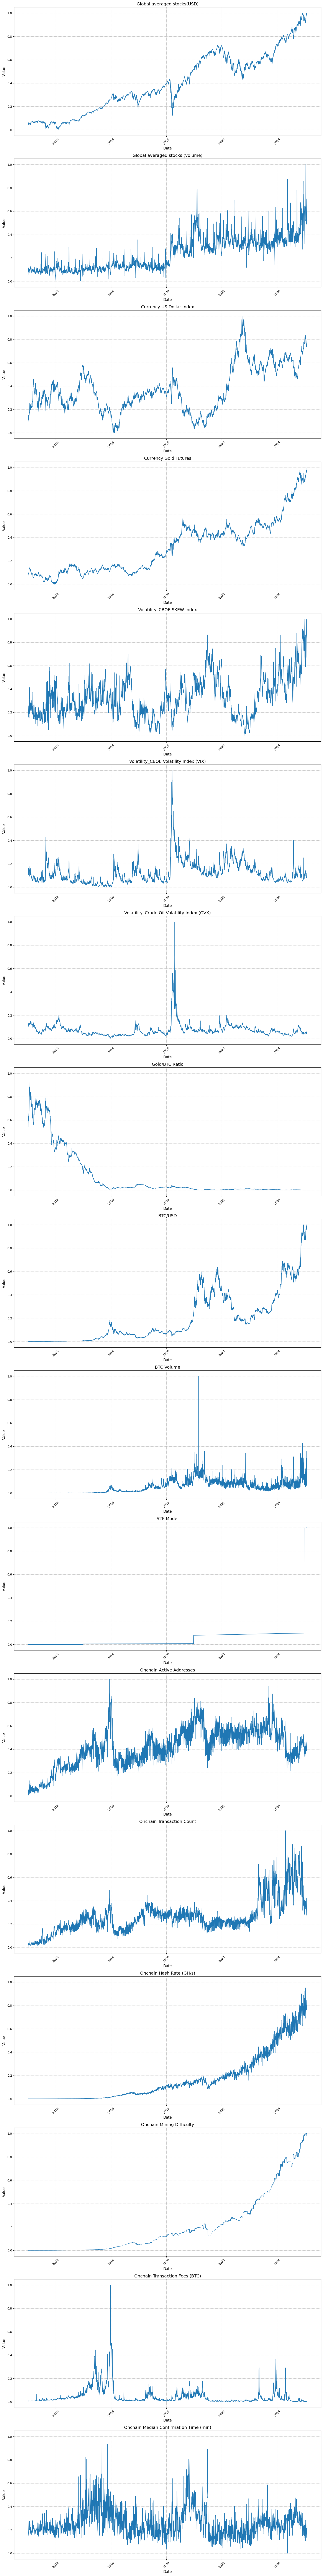

In [137]:
df = pd.read_csv(output_dir / "2015-2025_dataset_normalized.csv", index_col=0, parse_dates=True)

# Create subplots for each column
n_cols = len(df.columns)
fig, axes = plt.subplots(n_cols, 1, figsize=(15, 7*n_cols))

# Plot each column
for i, column in enumerate(df.columns):
    # Create the plot on the corresponding subplot
    axes[i].plot(df.index, df[column])
    
    # Customize each subplot
    axes[i].set_title(f'{column}', fontsize=14)
    axes[i].set_xlabel('Date', fontsize=12)
    axes[i].set_ylabel('Value', fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.7)
    
    # Rotate x-axis labels for better readability
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show all plots
plt.show()

http://dx.doi.org/10.3390/info12100388 - how to pre-process! [decription of how to do "wavelet decomposition" and/or "wavelet" denoising]

Instead of handling outliers in a more traditional approach, since financial data is real world data and I am not versed enough in finance and economics to understand fully what kind of data could or should classify as "outliers" with much confidence. I instead would prefer to try "denoising" from the literacture I've found on the similar projects.

"Wavelet transforms analyse stock market trends over different periods and often show superior performance. Peng et al. (2021) demonstrated that combining multiresolution wavelet reconstruction with deep learning significantly improves medium-term stock prediction accuracy, achieving a 75% hit rate for US stocks. Another study introduced the Adaptive Multi-Scale Wavelet Neural Network (AMSW-NN), which performs well but depends on dataset quality (Ouyang et al., 2021)." - https://arxiv.org/html/2408.12408v1#S3.SS3 TL;DR "multiresolution wavelet reconstruction"  is very good and preferable over "adaptive Multi-Scale Wavelet Neural Network (AMSW-NN)" due to its increased dependance on quality data. - "multiresolution wavelet" method explained in greater detail here: Peng et al. (2021) [https://www.mdpi.com/2078-2489/12/10/388] - only had a 0.63% improvement with much greater complexity, Best to keep things simple for both my sanity in programming and the "computational efficienty" of Pan Tang, Cheng Tang and Keren Wang's [https://doi.org/10.1002/for.3071] apporach:


"LSTM (long short-term memory), we propose a hybrid model of wavelet transform (WT) and multi-input LSTM"

LSTM + WT = flexible model.

"level 1 decomposition with db4 mother wavelet to eliminate noise. originall used in image processing. it is more widely
used in stock price forecasting (Aussem, 1998; Alru-maih & Al-Fawzan, 2002; Caetano & Yoneyama, 2007; Huang, 2011)"

y[n] = Σ x[k]g[2n-k]  # Low-pass filter
y[n] = Σ x[k]h[2n-k]  # High-pass filter

"db4" stands for "Daubechies-4" wavelet
It's called a "mother" wavelet because it's the original pattern that gets scaled and shifted
The "4" represents the number of vanishing moments (a measure of complexity)

Tang's Approach (2024):
Simple level 1 decomposition with db4
Complete zeroing of high-frequency coefficients
Claimed Results:
> Test accuracy increased from 51.72% - 57.76% to 64.66% - 72.19% after applying their denoising method
> Focused on LSTM model performance improvement
López Gil/Peng's Approach (2021, 2024):
Multi-level (3-level) decomposition with db4
Adaptive thresholding at each level
López Gil's Results:
> Achieved 72.82% test accuracy and 73.16% F1 score on the EWZ daily dataset
Peng's Original Results:
> Achieved 75% hit rate for US stocks


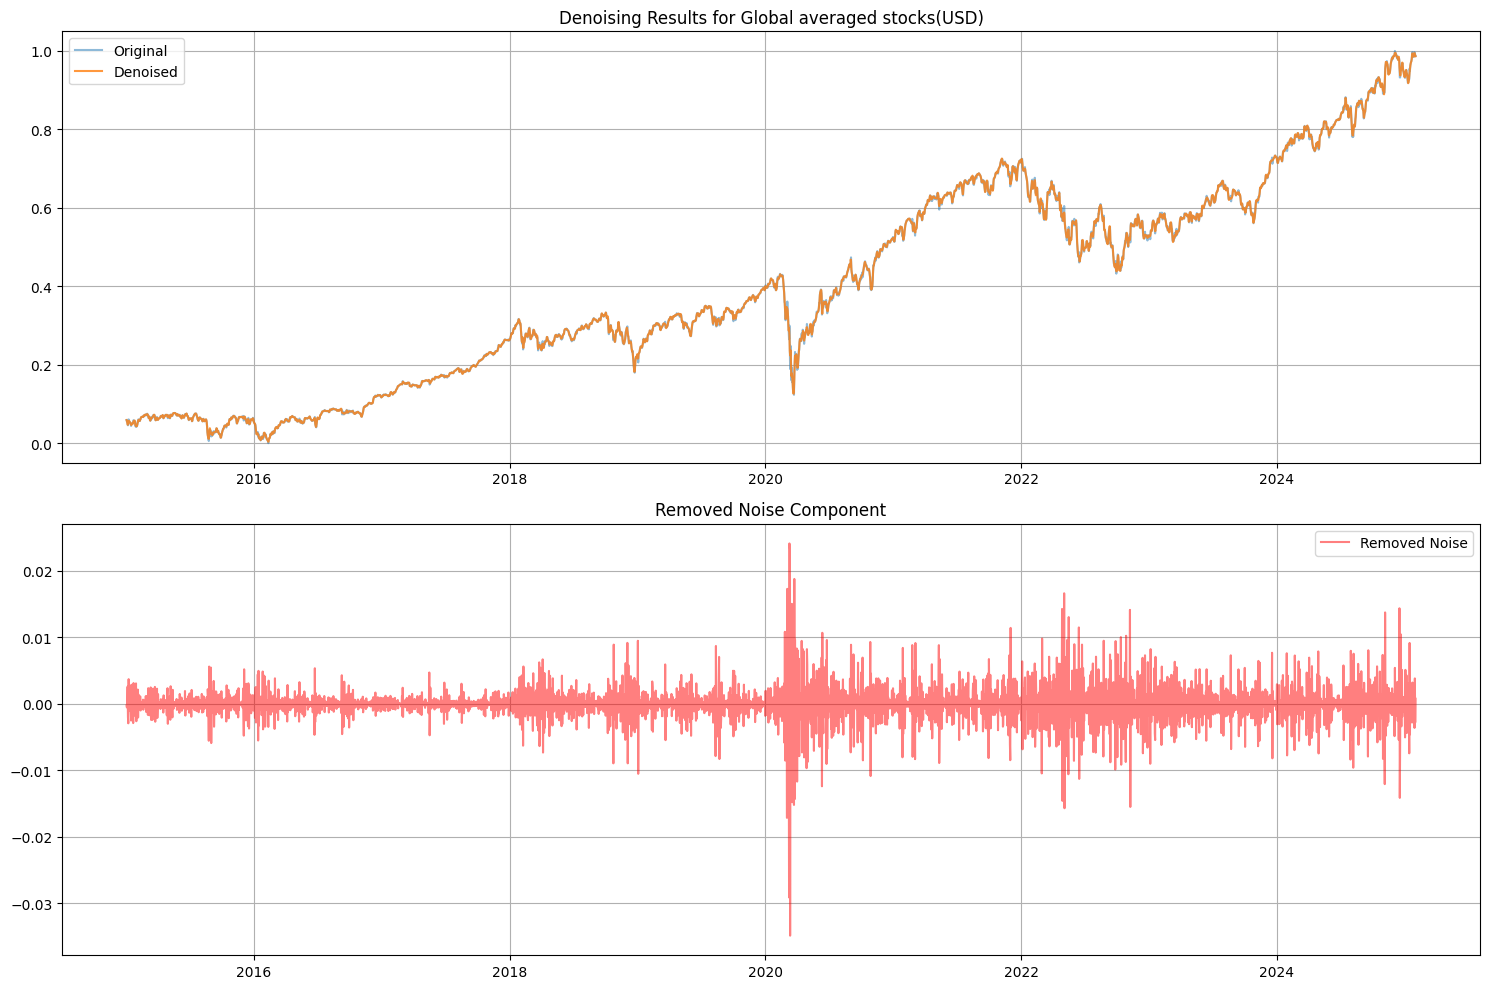

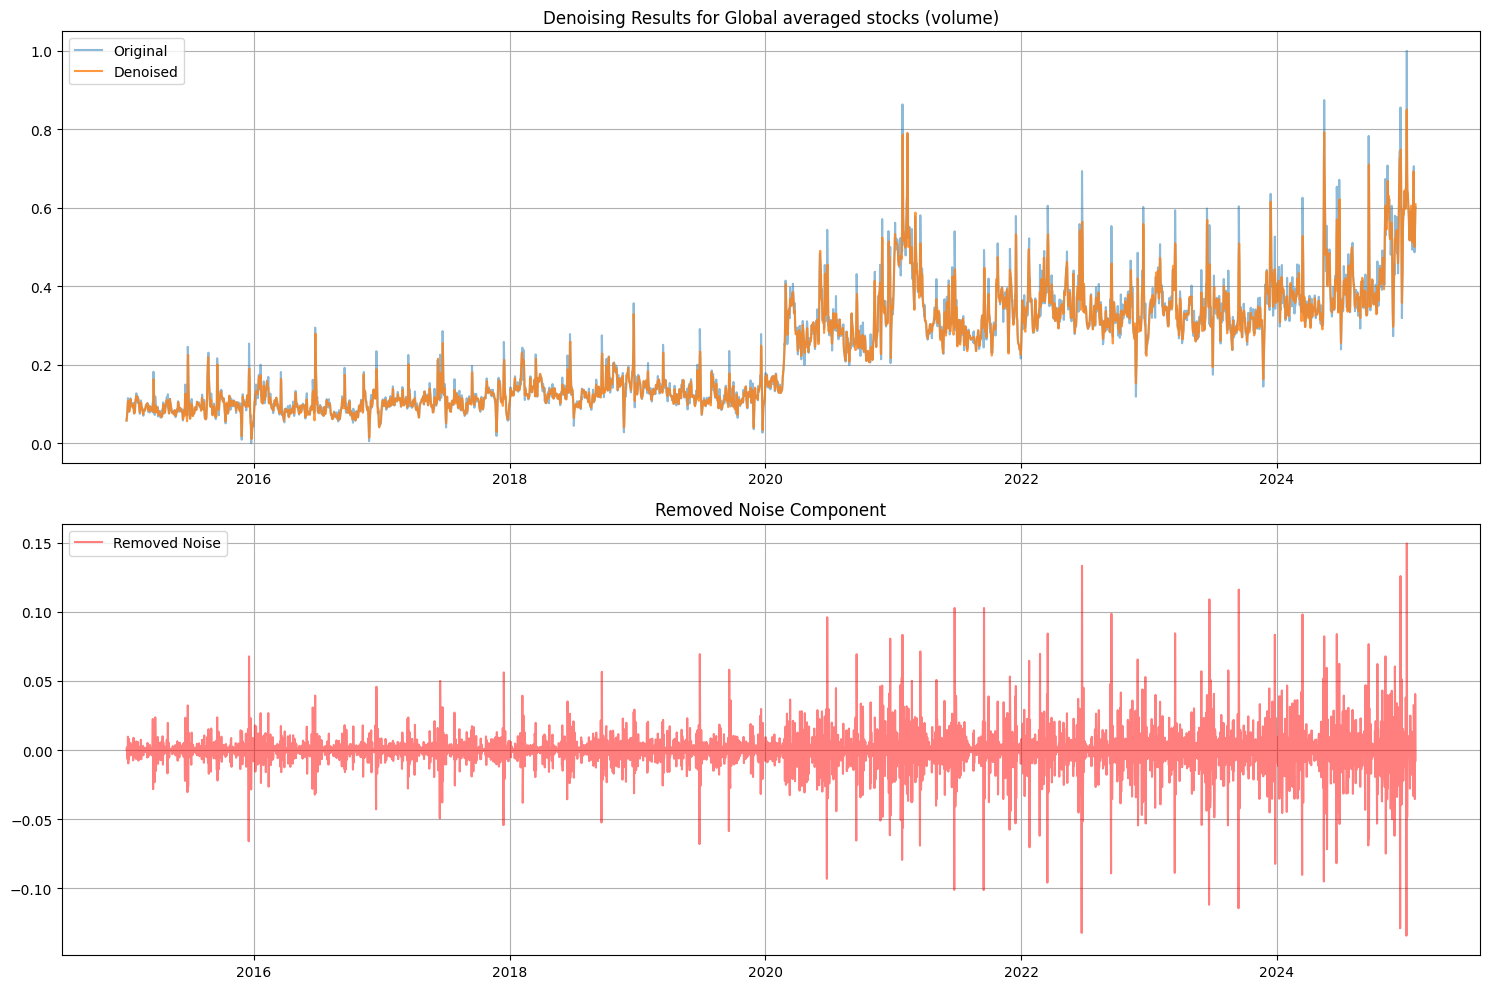

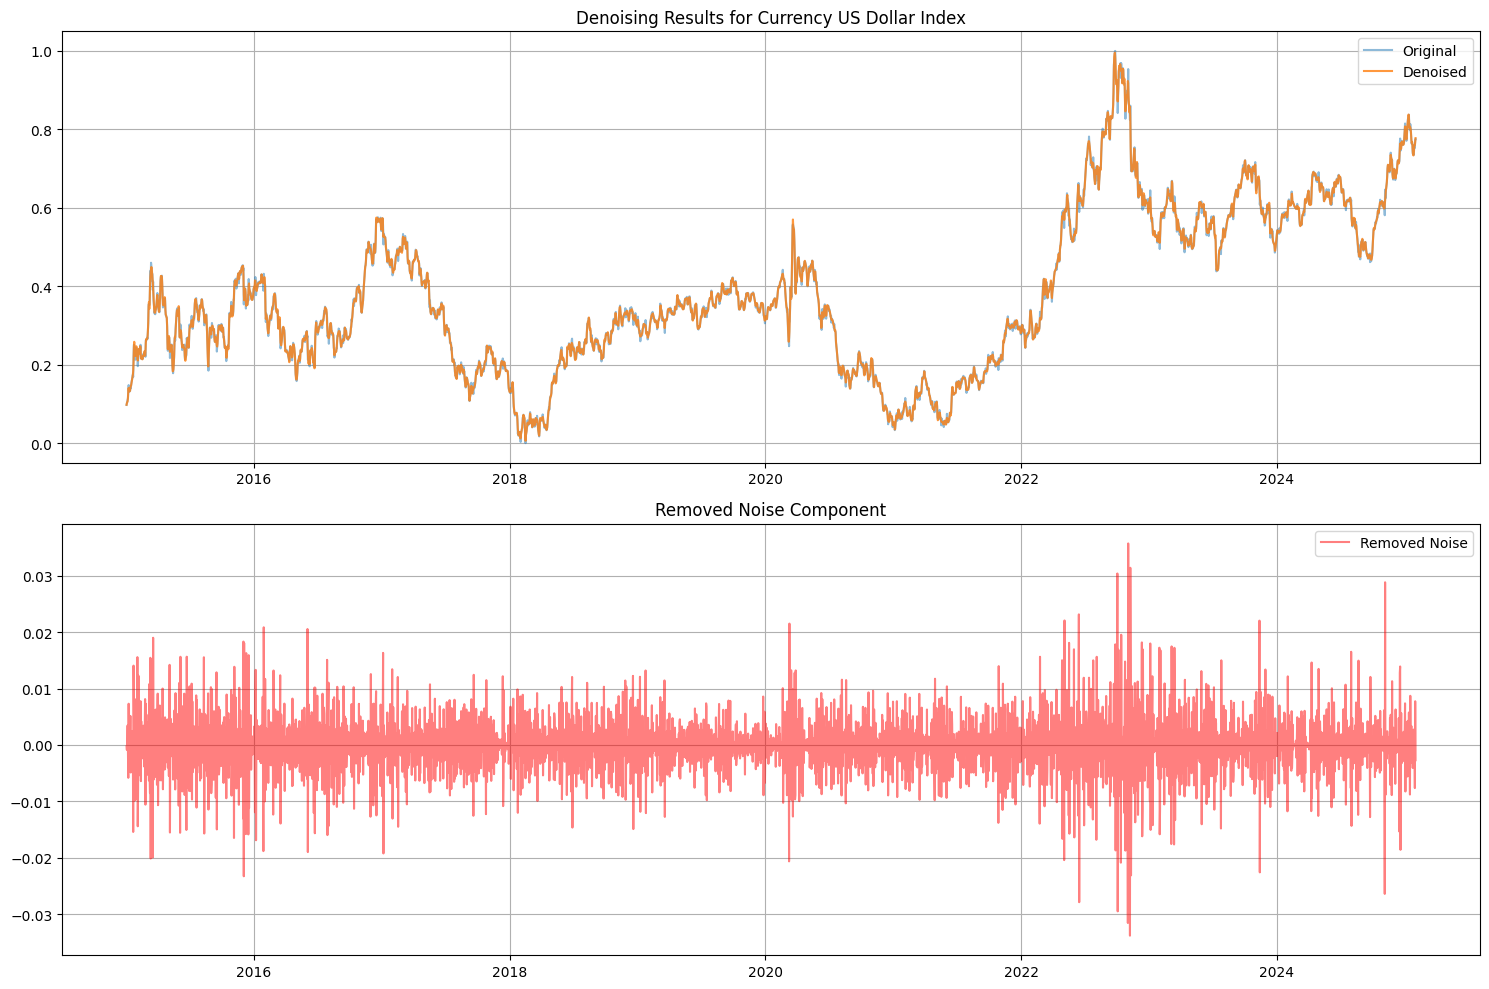

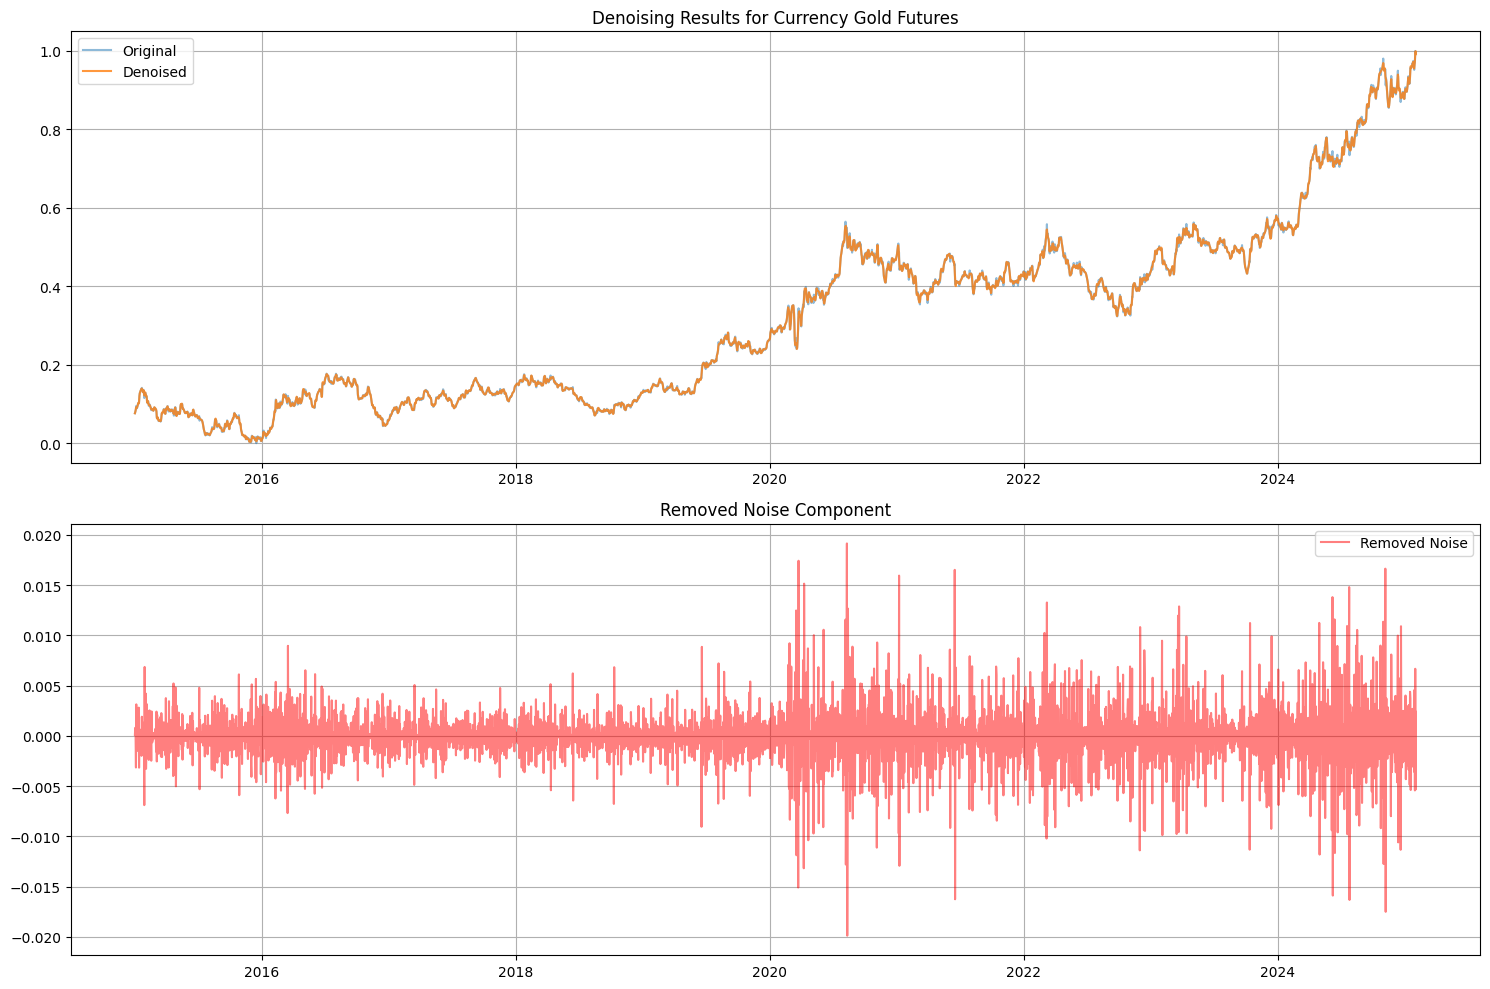

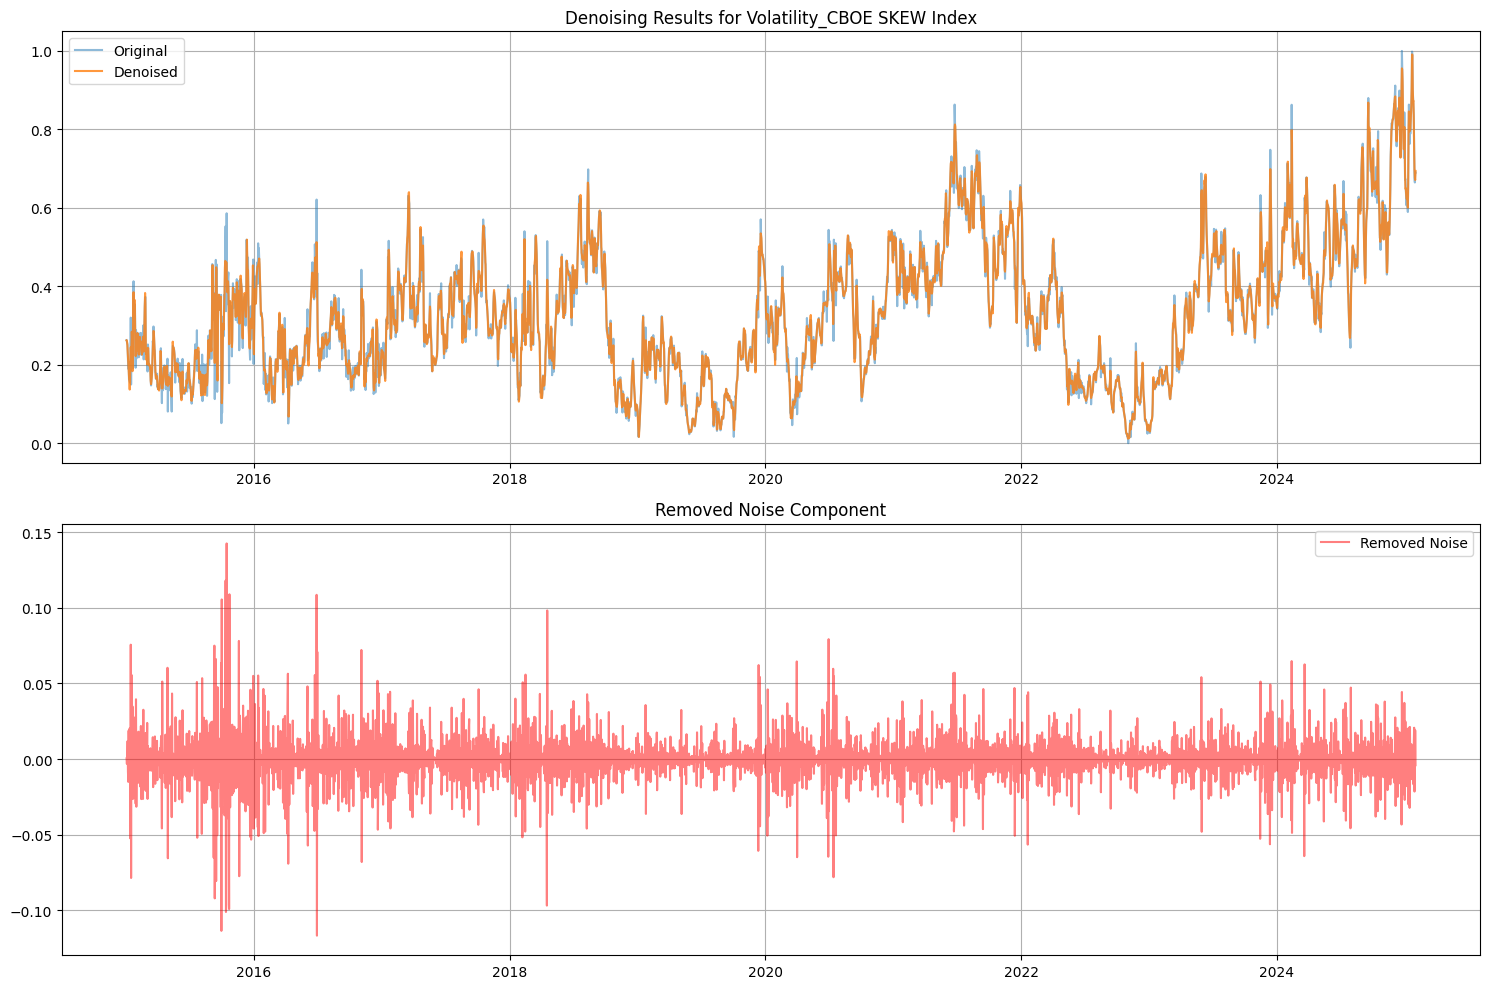

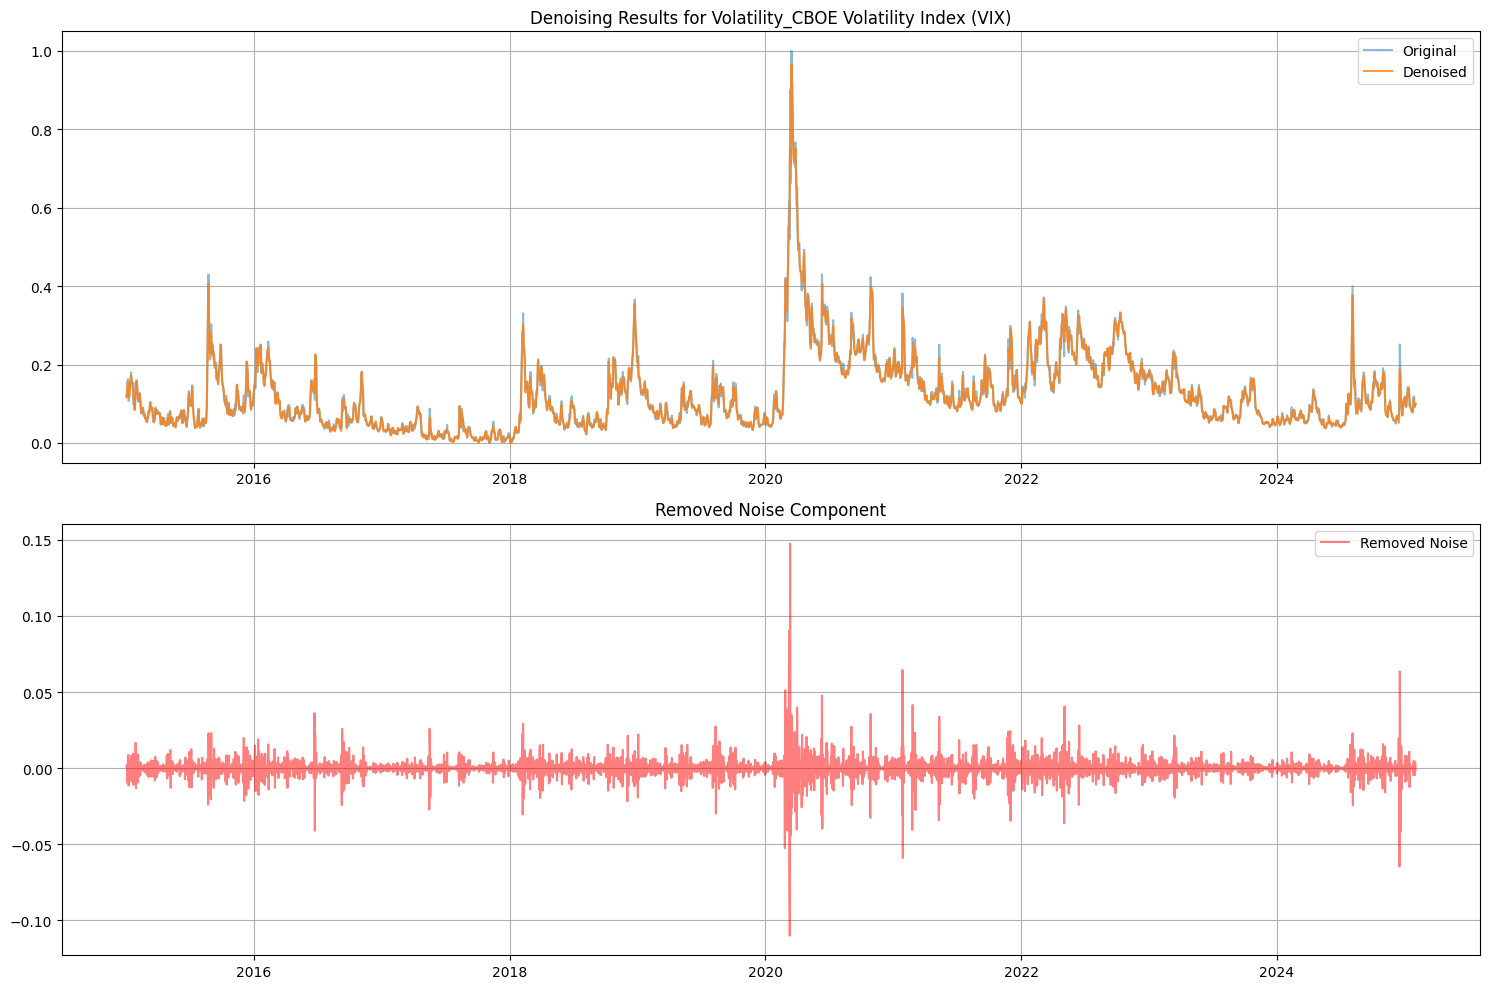

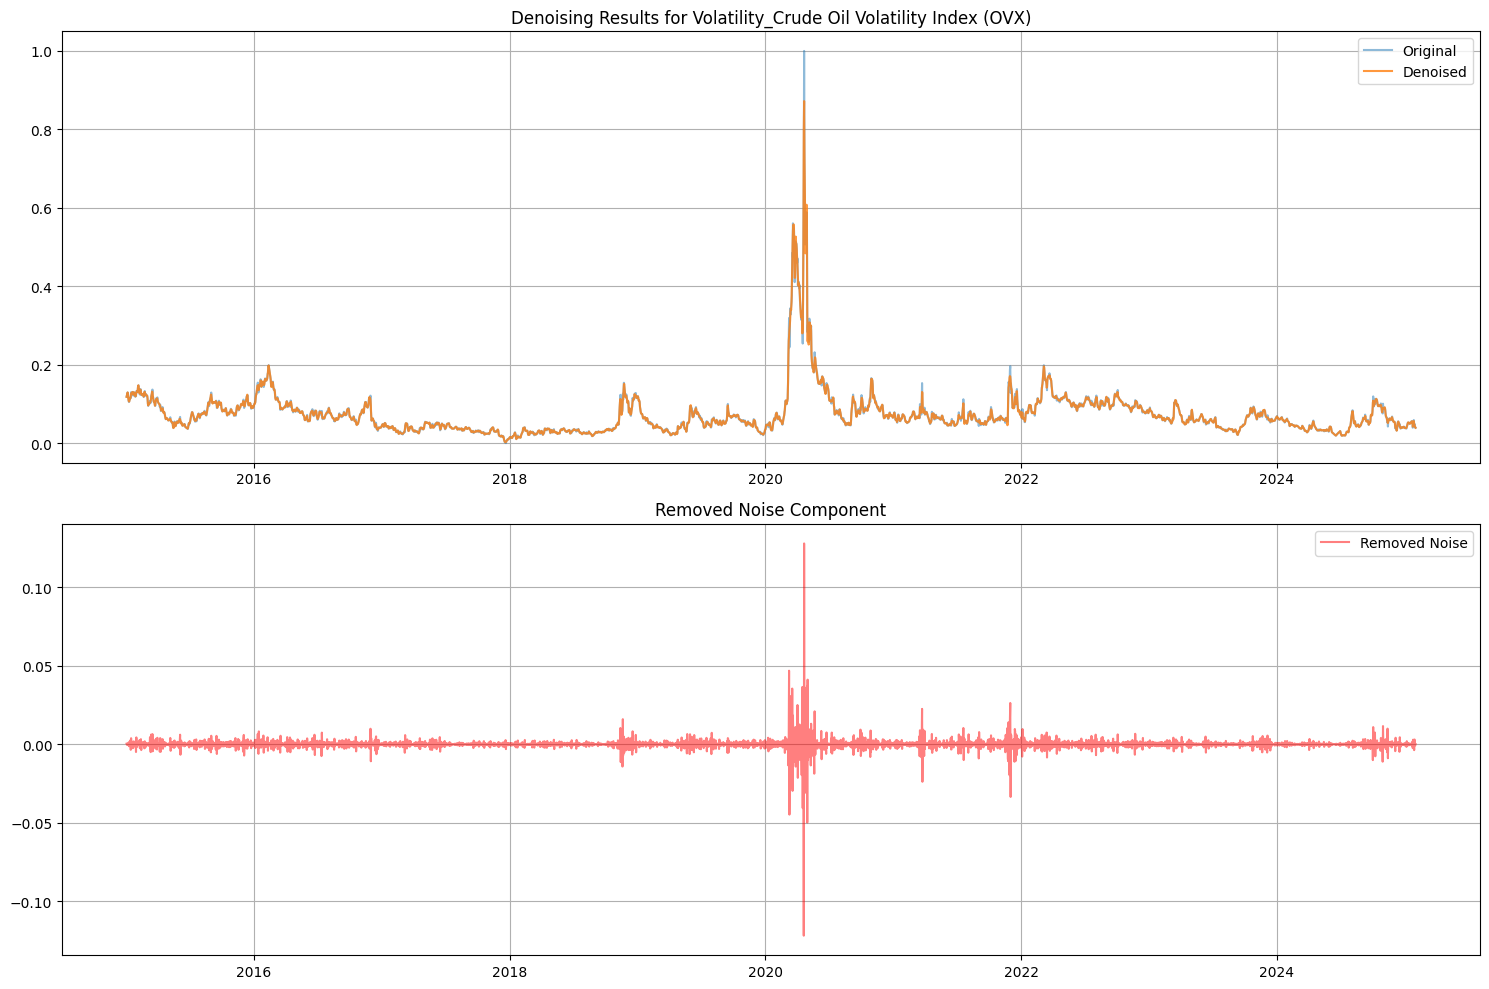

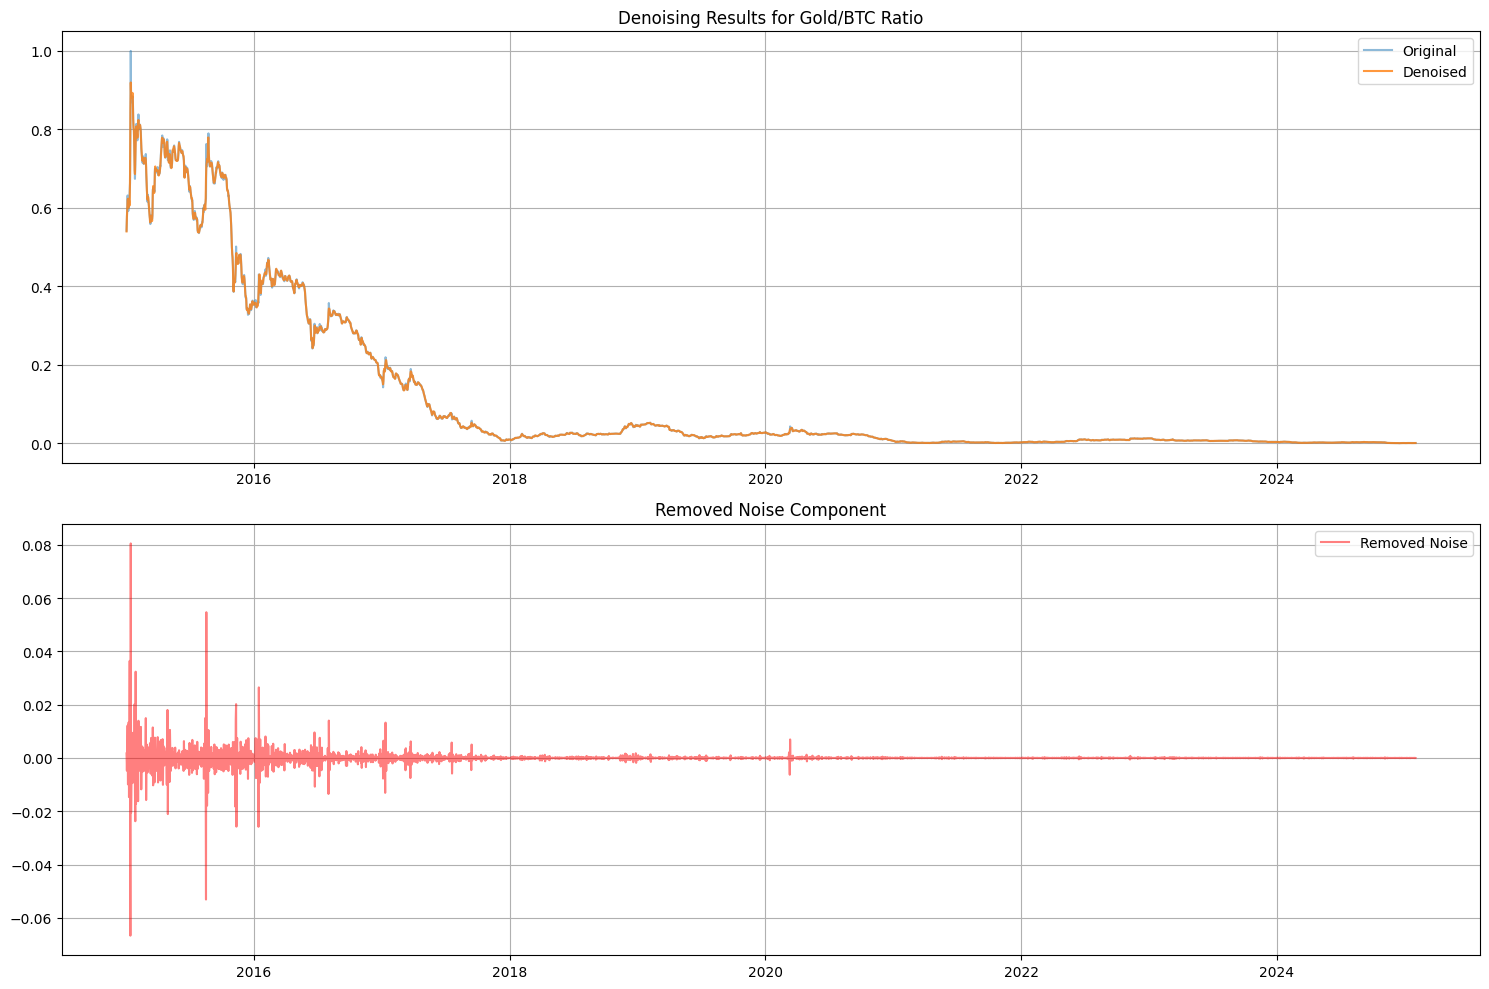

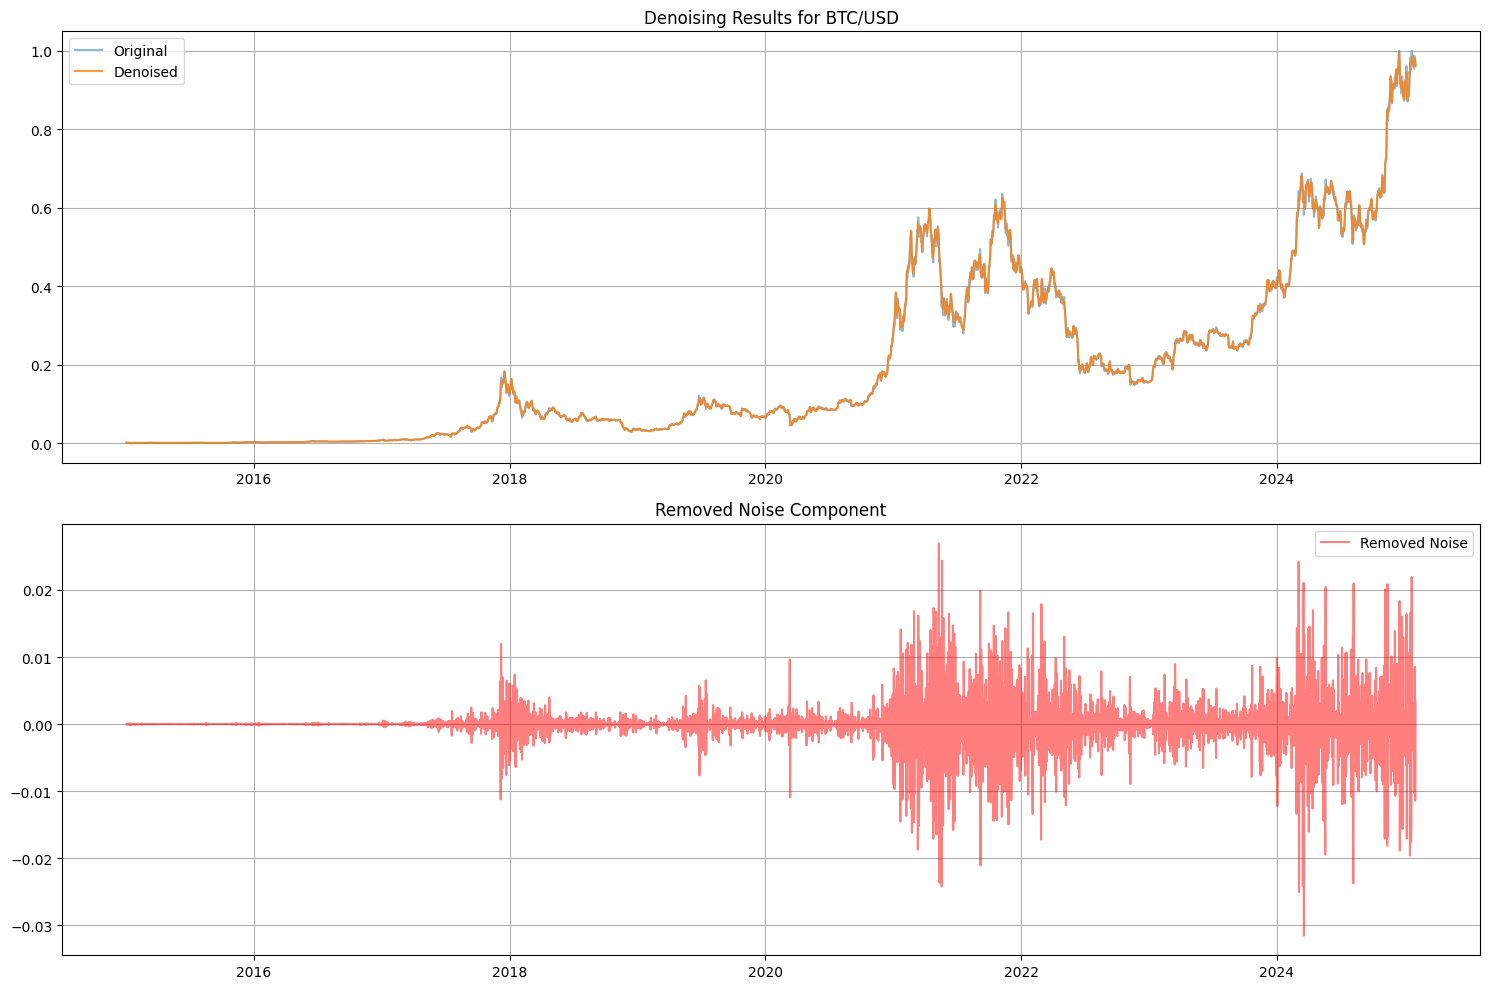

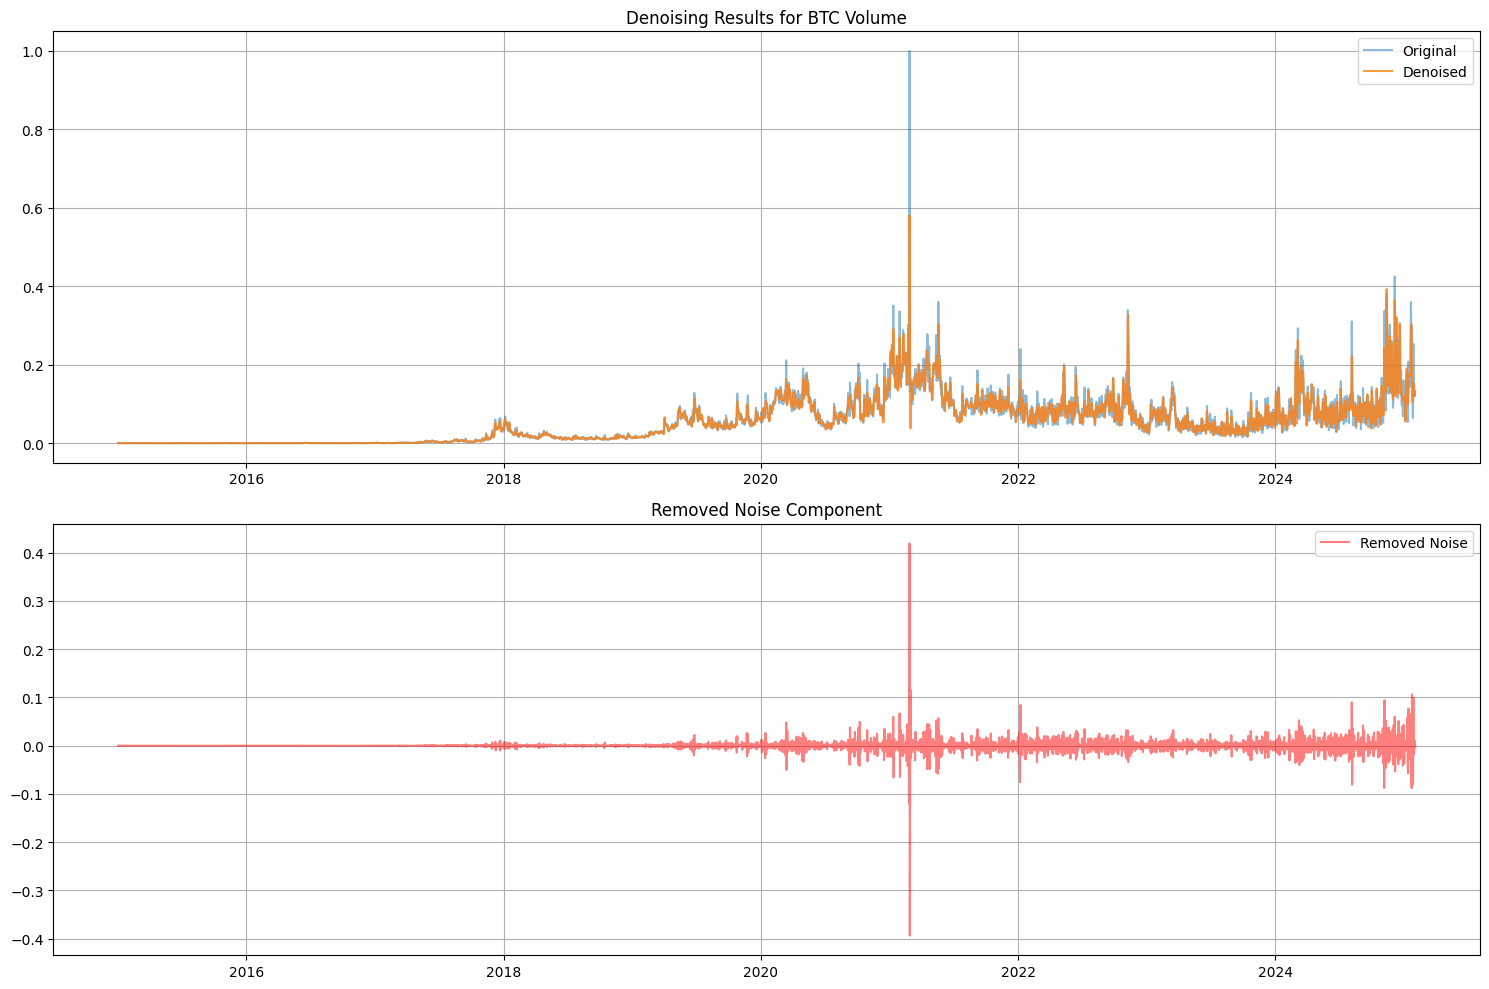

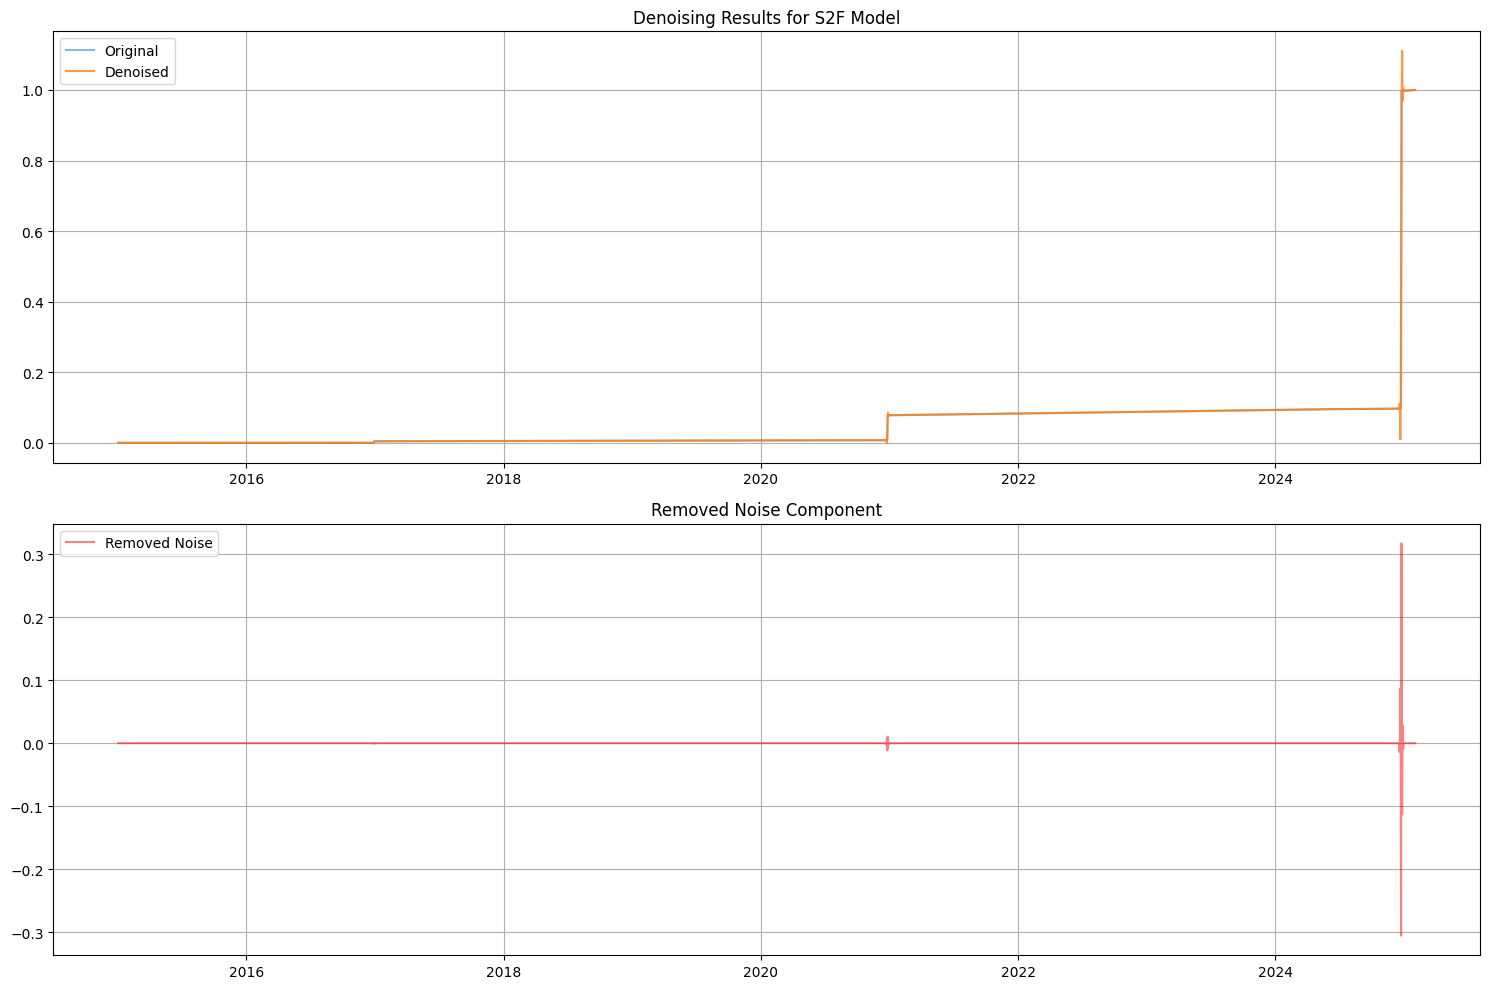

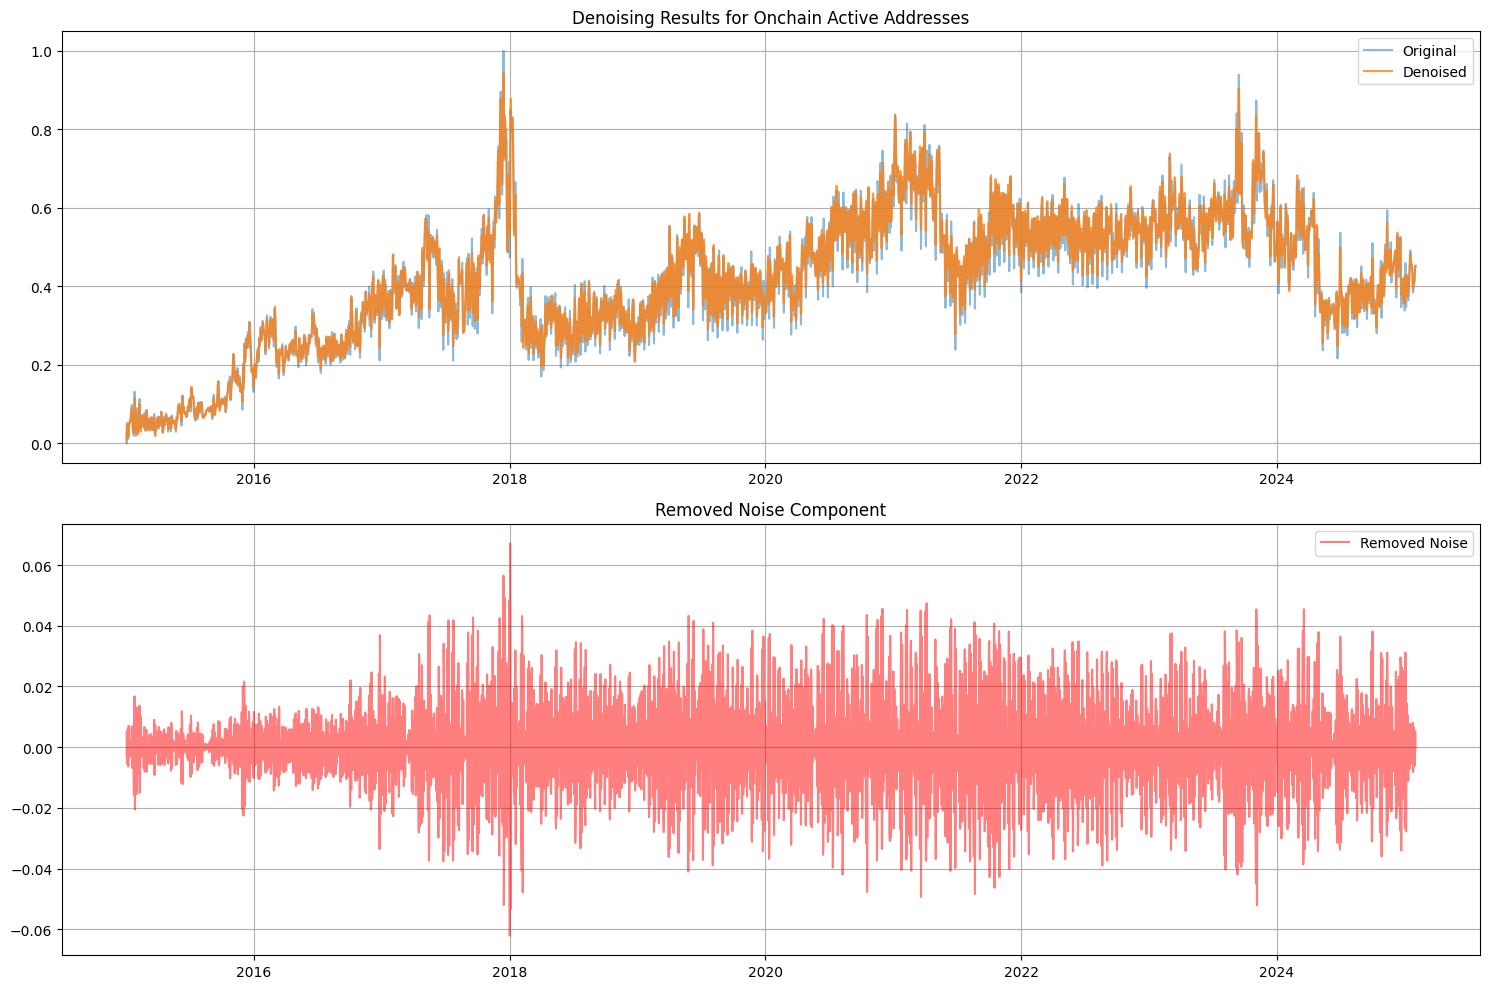

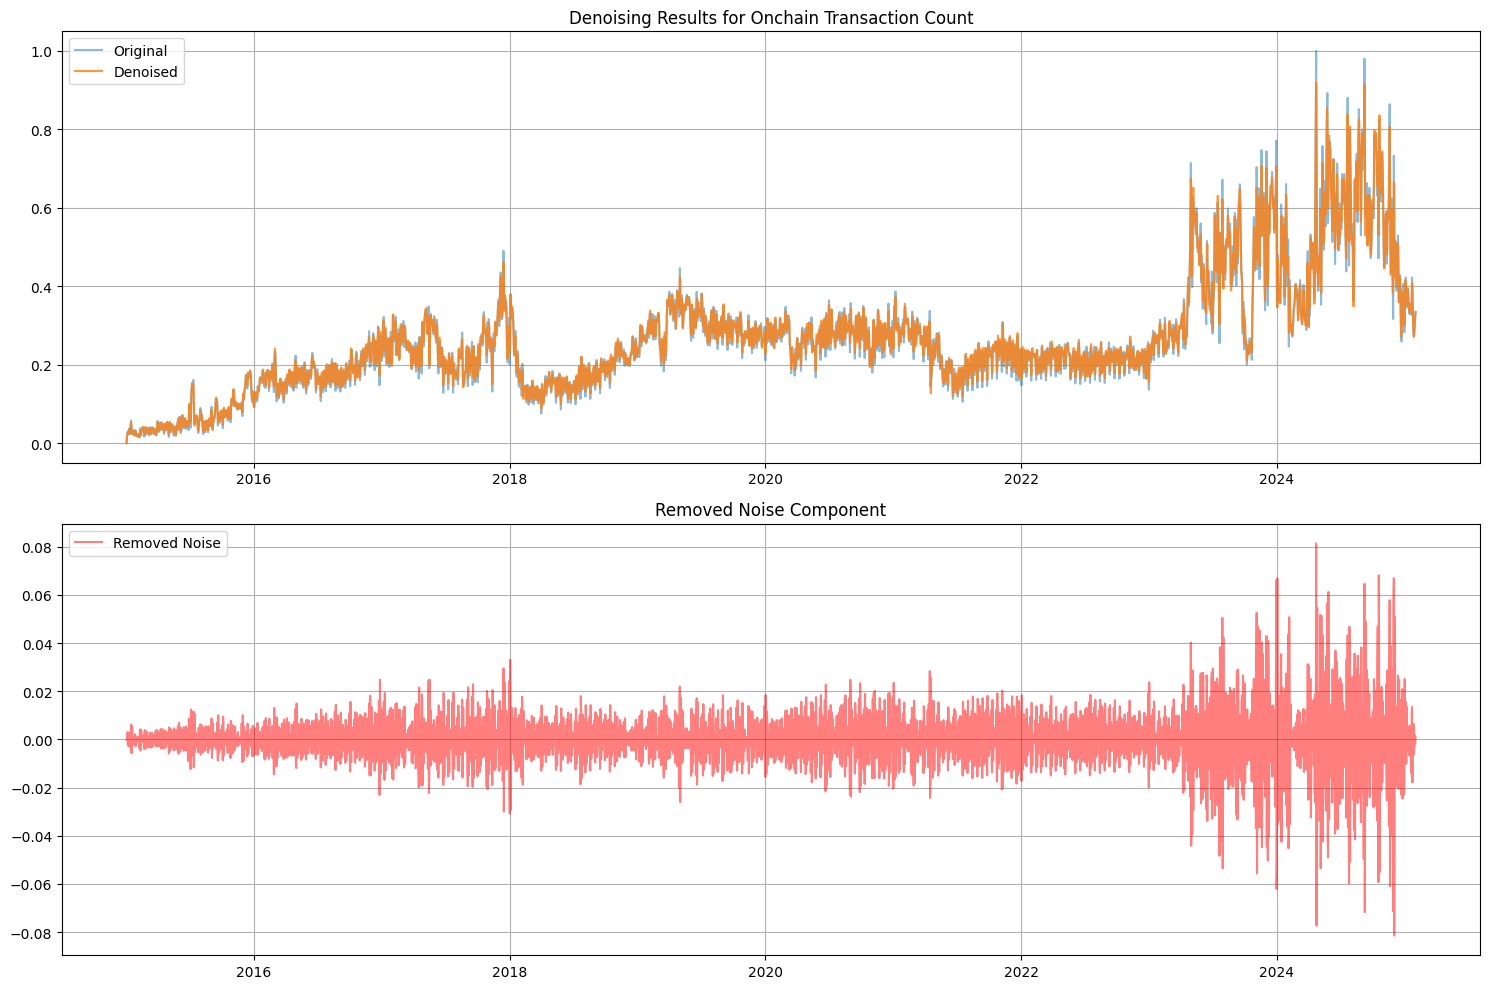

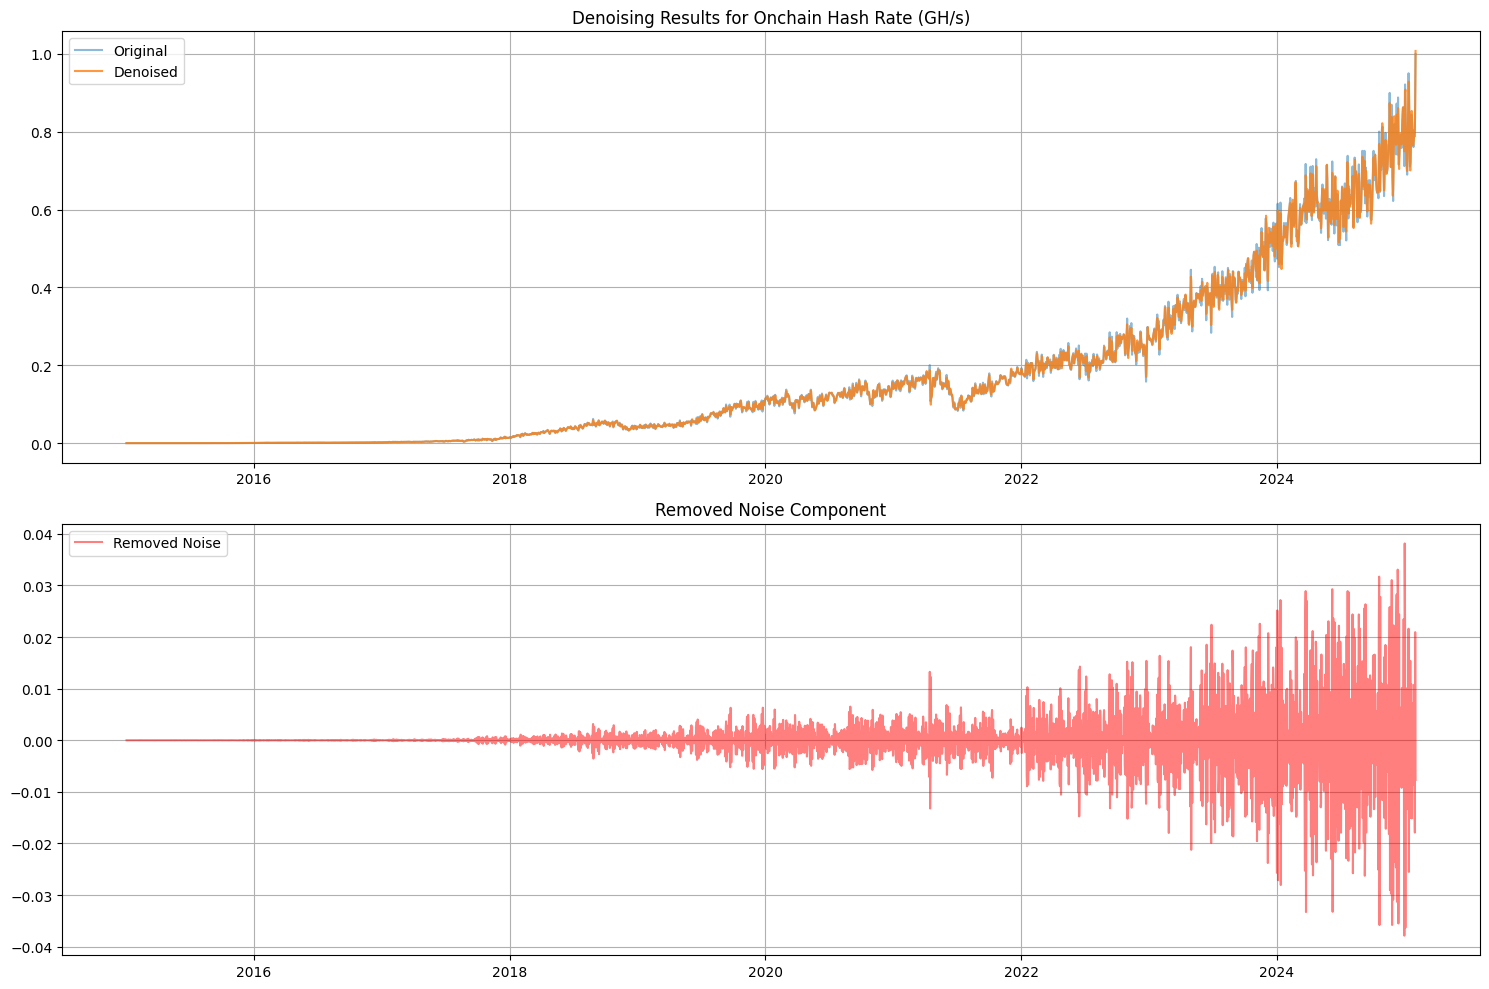

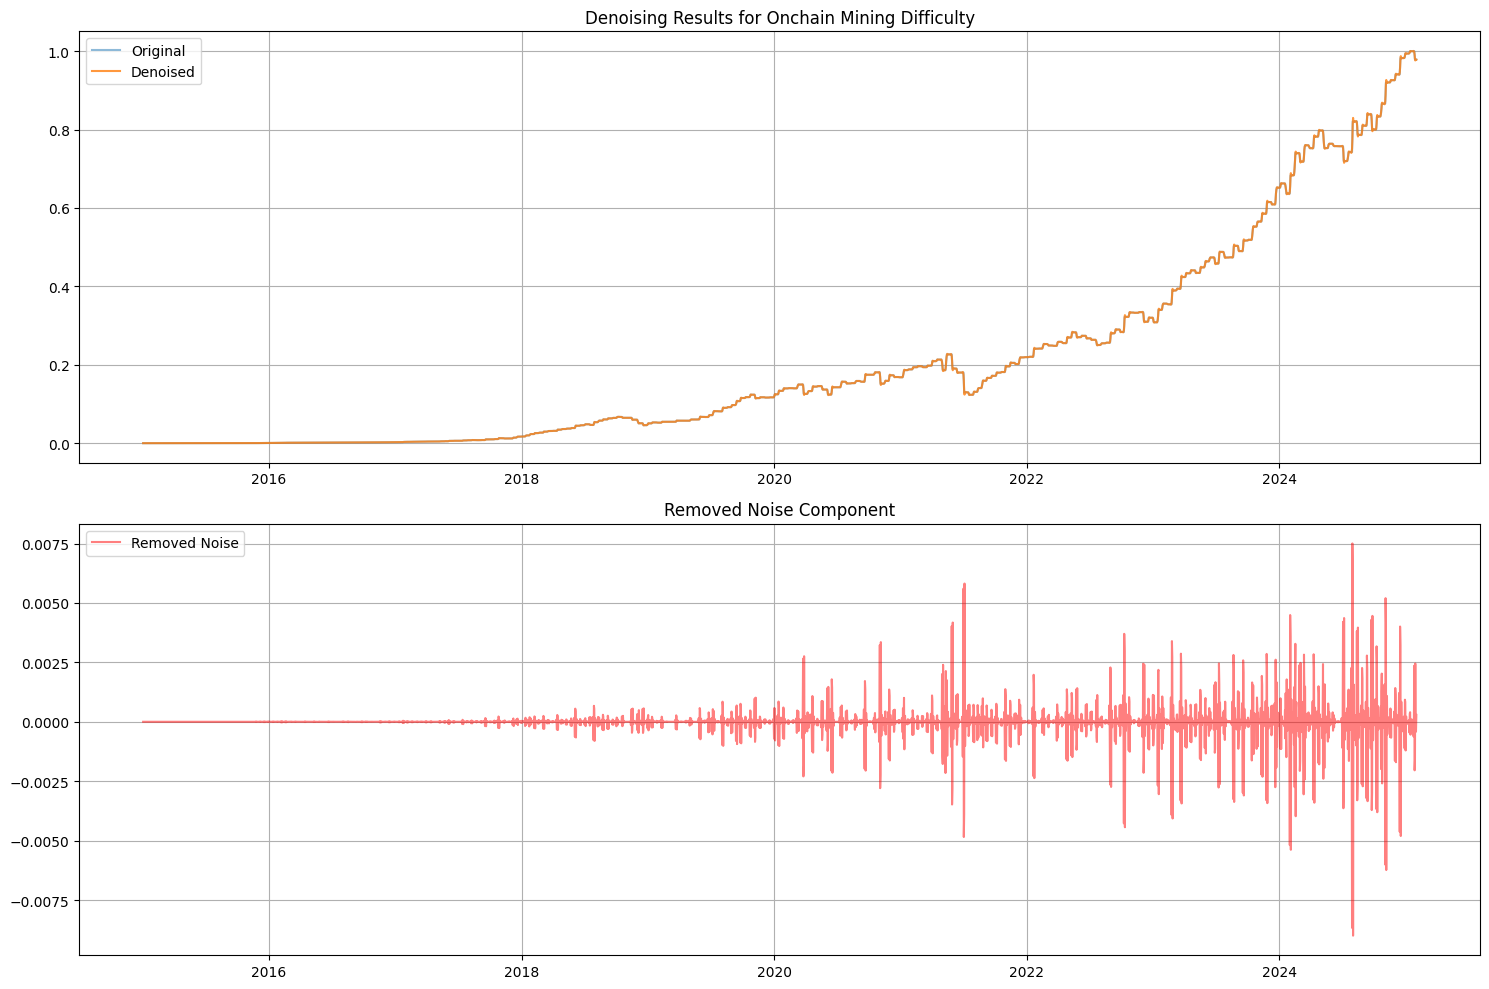

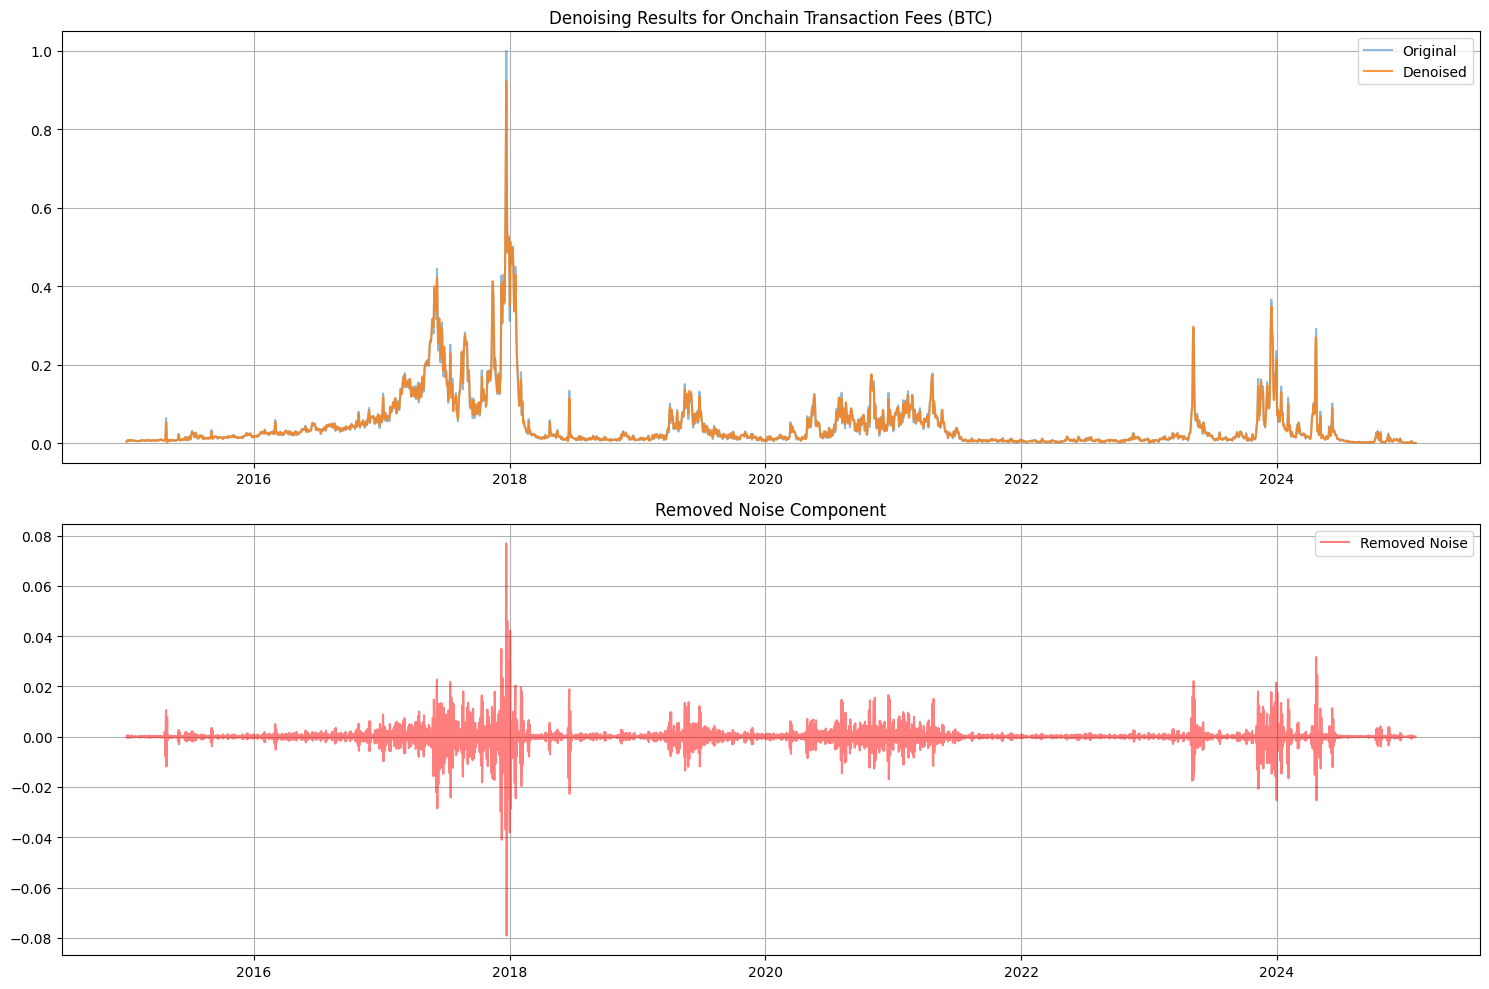

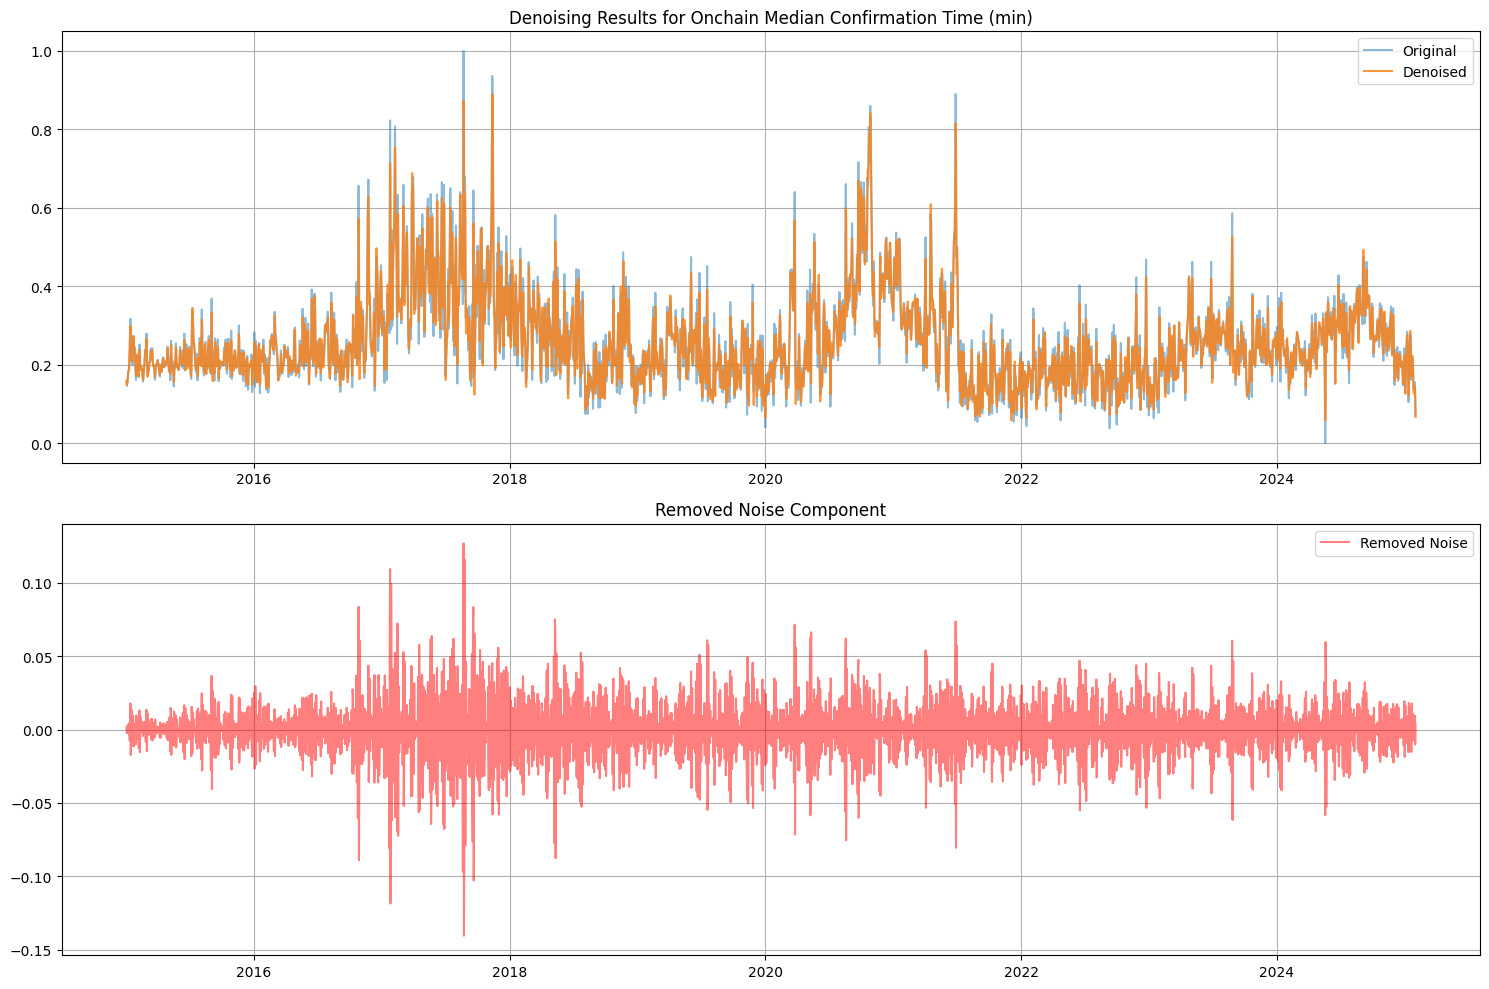

In [130]:
# Claude AI helped a lot here:
def wavelet_denoising(df, wavelet='db4'):
    df_denoised = df.copy()
    
    for column in df.columns:
        # 1. Level 1 decomposition with db4
        coeffs = pywt.wavedec(df[column].values, wavelet, level=1)
        
        # 2. Zero out high-frequency coefficients (detail coefficients)
        coeffs_modified = list(coeffs)
        coeffs_modified[1] = np.zeros_like(coeffs[1])
        
        # 3. Reconstruct
        denoised_data = pywt.waverec(coeffs_modified, wavelet)
        
        # Handle length if needed
        if len(denoised_data) > len(df):
            denoised_data = denoised_data[:len(df)]
            
        df_denoised[column] = denoised_data
    
    return df_denoised

def plot_denoising_results(original_data, denoised_data, column_name):
    noise = original_data[column_name] - denoised_data[column_name]
    
    plt.figure(figsize=(15, 10))
    
    # Original and denoised data
    plt.subplot(2,1,1)
    plt.plot(original_data.index, original_data[column_name], 
             label='Original', alpha=0.5)
    plt.plot(denoised_data.index, denoised_data[column_name], 
             label='Denoised', alpha=0.8)
    plt.title(f'Denoising Results for {column_name}')
    plt.legend()
    plt.grid(True)
    
    # Removed noise
    plt.subplot(2,1,2)
    plt.plot(original_data.index, noise, label='Removed Noise', 
             alpha=0.5, color='red')
    plt.title('Removed Noise Component')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

df = pd.read_csv(output_dir / "2015-2025_dataset_normalized.csv", 
                    index_col=0, parse_dates=True)

df_denoised = wavelet_denoising(df)

for column in df.columns:
    plot_denoising_results(df, df_denoised, column)

df_denoised.to_csv(output_dir / "2015-2025_dataset_denoised.csv")


Now for feature selection: [https://arxiv.org/pdf/2303.02223v2] (Chen's) - uses "Random Forest importance scores, Mutual Information, Correlation analysis" method for feature selection, with good success with "multi-input LSTM" (which I intent to use as my model of choice.)

[https://doi.org/10.1002/for.3071] - Teng's method

[https://www.mdpi.com/1999-4893/10/4/114] - tyralis's method

tyralis: Uses Random Forest with rolling windows, Calculates permutation importance (how much performance drops when feature is shuffled, Selects features scoring above (mean + std) threshold.

Tang: Fixed threshold with RF importance.

Chen: Adaptive weighting based on market volatility.

In [131]:
# main block: # Claude AI helped a lot here:
def load_data(filepath):
    df = pd.read_csv(filepath, index_col=0, parse_dates=True)
    return df

def save_selected_features(df, selected_features, target, method_name):
    final_features = selected_features + [target]
    df_selected = df[final_features]
    output_path = output_dir / f"2015-2025_dataset_selected_features_{method_name}.csv"
    df_selected.to_csv(output_path)
    return df_selected.shape

def plot_feature_importance(scores_df, method_name):
    plt.figure(figsize=(12, 6))
    scores_df.sort_values('Score', ascending=True).plot(kind='barh')
    plt.title(f'Feature Importance Scores - {method_name}')
    plt.xlabel('Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show(output_dir / f'feature_importance_{method_name}.png')
    plt.close()

In [132]:
# tyralis's method, Claude AI helped a lot here:
def tyralis_selection(df, target='BTC/USD', forecast_horizon=1):
    X = df.drop(target, axis=1)
    y = df[target]
    
    def calculate_permutation_importance(X_train, y_train, X_val, y_val):
        rf = RandomForestRegressor(n_estimators=500,  
                                 max_features='sqrt',  
                                 random_state=42)
        rf.fit(X_train, y_train)
        
        # Calculate permutation importance
        importances = []
        baseline_score = rf.score(X_val, y_val)
        
        for col in X_train.columns:
            X_val_permuted = X_val.copy()
            X_val_permuted[col] = np.random.permutation(X_val_permuted[col])
            permuted_score = rf.score(X_val_permuted, y_val)
            importance = baseline_score - permuted_score
            importances.append(importance)
            
        return pd.Series(importances, index=X_train.columns)
    
    # Rolling origin evaluation
    importance_scores = []
    window_size = len(df) // 3  # Minimum training size
    
    for i in range(window_size, len(df) - forecast_horizon):
        # Training and validation sets
        X_train = X.iloc[i-window_size:i]
        y_train = y.iloc[i-window_size:i]
        X_val = X.iloc[i:i+forecast_horizon]
        y_val = y.iloc[i:i+forecast_horizon]
        
        # Calculate importance for this window
        window_importance = calculate_permutation_importance(
            X_train, y_train, X_val, y_val
        )
        importance_scores.append(window_importance)
    
    # Average importance scores across all windows
    final_importance = pd.DataFrame(importance_scores).mean()
    
    # Select features
    threshold = final_importance.mean() + final_importance.std()
    selected_features = final_importance[final_importance > threshold]
    
    return selected_features.index.tolist(), pd.DataFrame({
        'Feature': final_importance.index,
        'Score': final_importance.values
    }).sort_values('Score', ascending=False)

In [133]:
# Teng's method, Claude AI helped a lot here:
def tang_selection(df, target='BTC/USD', threshold=0.1):
    X = df.drop(target, axis=1)
    y = df[target]
    
    # Random Forest importance
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Calculate importance scores
    importance_scores = pd.DataFrame({
        'Feature': X.columns,
        'Score': rf.feature_importances_
    }).sort_values('Score', ascending=False)

    selected_features = importance_scores[importance_scores['Score'] > threshold]
    
    return selected_features['Feature'].tolist(), importance_scores

In [134]:
# Chen's method, Claude AI helped a lot here:
def chen_selection(df, target='BTC/USD', volatility_window=30):
# adaptive weighting based on market volatility

    X = df.drop(target, axis=1)
    y = df[target]
    
    # Calculate market volatility
    returns = df[target].pct_change()
    volatility = returns.rolling(window=volatility_window).std().iloc[-1]
    
    # Calculate Information Value
    def calculate_iv(feature):
        bins = pd.qcut(feature, q=10, duplicates='drop')
        iv = mutual_info_regression(feature.values.reshape(-1, 1), y)[0]
        return iv
    
    iv_scores = pd.Series({col: calculate_iv(X[col]) for col in X.columns})
    
    # Calculate Stability Index
    def calculate_psi(feature):
        mid_point = len(feature) // 2
        hist1, _ = np.histogram(feature[:mid_point], bins=10)
        hist2, _ = np.histogram(feature[mid_point:], bins=10)
        hist1 = hist1/sum(hist1)
        hist2 = hist2/sum(hist2)
        hist1 = np.clip(hist1, 0.0001, None)
        hist2 = np.clip(hist2, 0.0001, None)
        return np.sum((hist1 - hist2) * np.log(hist1/hist2))
    
    psi_scores = pd.Series({col: calculate_psi(X[col]) for col in X.columns})
    
    # Random Forest importance
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    rf_scores = pd.Series(rf.feature_importances_, index=X.columns)
    
    # Normalize scores
    iv_norm = (iv_scores - iv_scores.min()) / (iv_scores.max() - iv_scores.min())
    psi_norm = 1 - (psi_scores - psi_scores.min()) / (psi_scores.max() - psi_scores.min())
    rf_norm = (rf_scores - rf_scores.min()) / (rf_scores.max() - rf_scores.min())
    
    # Adaptive weights based on volatility
    if volatility > 0.02:  # High volatility
        weights = {'iv': 0.4, 'psi': 0.4, 'rf': 0.2}
    else:  # Normal conditions
        weights = {'iv': 0.3, 'psi': 0.2, 'rf': 0.5}
    
    # Calculate final scores
    final_scores = pd.DataFrame({
        'Feature': X.columns,
        'Score': weights['iv'] * iv_norm + weights['psi'] * psi_norm + weights['rf'] * rf_norm
    }).sort_values('Score', ascending=False)
    
    # Select features above 75th percentile
    threshold = final_scores['Score'].quantile(0.75)
    selected_features = final_scores[final_scores['Score'] > threshold]
    
    return selected_features['Feature'].tolist(), final_scores

<Figure size 1200x600 with 0 Axes>

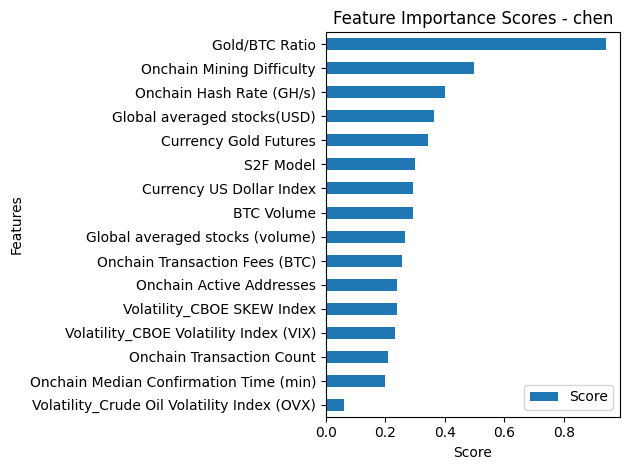

Selected 4 features
Features: Gold/BTC Ratio, Onchain Mining Difficulty, Onchain Hash Rate (GH/s), Global averaged stocks(USD)
Output shape: (3684, 5)


In [135]:
# Claude AI helped a lot here:
def run_feature_selection(method_choice='chen'):
    df = pd.read_csv(output_dir / "2015-2025_dataset_denoised.csv", 
                    index_col=0, parse_dates=True)
    target = 'BTC/USD'
    
    methods = {
        'tyralis': tyralis_selection,
        'tang': tang_selection,
        'chen': chen_selection
    }
    
    selected_features, importance_scores = methods[method_choice](df, target)
    
    shape = save_selected_features(df, selected_features, target, method_choice)
    
    plot_feature_importance(importance_scores, method_choice)
    
    print(f"Selected {len(selected_features)} features")
    print("Features:", ', '.join(selected_features))
    print(f"Output shape: {shape}")

run_feature_selection('chen')